# Comparative Non-B DNA Structural Motif Analysis
## Nine-Genome Study — Classes, Subclasses, Hybrids, and Clusters

This notebook provides a **rigorous comparative analysis** of Non-B DNA structural motifs
detected by **NonBDNAFinder** across nine genomes spanning three domains of life:

| Domain | Organism | Lifestyle |
|--------|----------|-----------|
| Bacteria | *Escherichia coli* | Free-living, ~4.6 Mb |
| Bacteria | *Helicobacter pylori* | Pathogen, ~1.7 Mb |
| Bacteria | *Staphylococcus aureus* | Pathogen, ~2.8 Mb |
| Bacteria | *Streptococcus pneumoniae* | Pathogen, ~2.1 Mb |
| Bacteria | *Cellulomonas shaoxiangyii* | Soil, ~3.9 Mb |
| Bacteria | *Miltoncostaea marina* | Marine, ~3.4 Mb |
| Obligate endosymbiont | *Buchnera aphidicola* | Intracellular, ~452 kb |
| Obligate endosymbiont | *Candidatus Carsonella ruddii* | Intracellular, ~174 kb |
| Eukaryote | *Saccharomyces cerevisiae* | Free-living, ~12.2 Mb |

The analysis covers:
1. **Genome-level overview** — size, total motifs, density, coverage, occupancy
2. **Class-level analysis** — raw counts and normalised densities of all 11 Non-B DNA classes
3. **Subclass-level analysis** — major structural variants within each class
4. **Hybrid region analysis** — overlapping multi-class loci
5. **Cluster region analysis** — high-density Non-B DNA windows
6. **Structural complexity metrics** — SLI, SCI, WSC, overlap depth
7. **Diversity indices** — Simpson D, effective class number (N_eff), structural dominance


## Cell 1 · Setup — Imports and Data Loading

In [1]:
# ── Imports ───────────────────────────────────────────────────────────────────
import os, re, warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

warnings.filterwarnings("ignore")
matplotlib.rcParams.update({
    "figure.dpi": 150,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
})

# ── Locate genome directories ─────────────────────────────────────────────────
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
GENOME_DIRS = sorted([d for d in os.listdir(BASE_DIR) if d.endswith("_genome")])
ORGANISMS   = [d.replace("_genome", "") for d in GENOME_DIRS]

SHORT_NAMES = {
    "Buchnera aphidicola":           "B. aphidicola",
    "Candidatus Carsonella ruddii":  "Ca. Carsonella",
    "Cellulomonas shaoxiangyii":     "C. shaoxiangyii",
    "Escherichia coli":              "E. coli",
    "Helicobacter pylori":           "H. pylori",
    "Miltoncostaea marina":          "M. marina",
    "Saccharomyces cerevisiae":      "S. cerevisiae",
    "Staphylococcus aureus":         "S. aureus",
    "Streptococcus pneumoniae":      "S. pneumoniae",
}
SHORT = [SHORT_NAMES.get(o, o) for o in ORGANISMS]

print(f"Found {len(GENOME_DIRS)} genome directories:")
for org, sn in zip(ORGANISMS, SHORT):
    print(f"  {org}  →  {sn}")

# ── Helper: parse numeric value from the CSV ─────────────────────────────────
def parse_val(v):
    """Strip units / commas and return float (NaN if unparseable)."""
    if pd.isna(v):
        return np.nan
    s = str(v).strip()
    s = re.sub(r"[,\s]*(bp|/\s*kb|%)?$", "", s)  # remove trailing unit
    s = s.replace(",", "").replace("%", "")
    try:
        return float(s)
    except ValueError:
        return np.nan

# ── Load comprehensive_genome_stats.csv for every genome ─────────────────────
stats_rows = []
for gd, org in zip(GENOME_DIRS, ORGANISMS):
    path = os.path.join(BASE_DIR, gd, "comprehensive_genome_stats.csv")
    df   = pd.read_csv(path)
    row  = {"Organism": org, "Short": SHORT_NAMES.get(org, org)}
    for _, r in df.iterrows():
        row[r["Metric"]] = parse_val(r["Value"])
    stats_rows.append(row)

STATS = pd.DataFrame(stats_rows).set_index("Organism")
print("\nGenome stats loaded:", STATS.shape)

# ── Sort genomes by genome size (ascending) ──────────────────────────────────
STATS = STATS.sort_values("Genome Length")
ORGANISMS = list(STATS.index)
SHORT = [SHORT_NAMES.get(o, o) for o in ORGANISMS]
GENOME_DIRS = [o + "_genome" for o in ORGANISMS]

# ── Load motifs.xlsx for every genome (cached) ───────────────────────────────
MOTIFS = {}
for gd, org in zip(GENOME_DIRS, ORGANISMS):
    path = os.path.join(BASE_DIR, gd, "motifs.xlsx")
    MOTIFS[org] = pd.read_excel(path)
    print(f"  {SHORT_NAMES.get(org,org):22s}: {len(MOTIFS[org]):>6,} motifs loaded")

# ── Colour palette for classes ────────────────────────────────────────────────
# Taxonomy order: bent/curved → palindromic/repeat → multi-stranded
# → alternative-helix → RNA-hybrid → quartet → composite
ALL_CLASSES = [
    "Curved_DNA", "A-philic_DNA", "Cruciform", "Slipped_DNA",
    "Triplex", "Z-DNA", "R-Loop", "G-Quadruplex", "i-Motif",
    "Hybrid", "Non-B_DNA_Clusters",
]
CLASS_COLORS = dict(zip(ALL_CLASSES, plt.cm.tab20.colors[:len(ALL_CLASSES)]))
print("\nAll Non-B DNA classes (taxonomy order):", ALL_CLASSES)

# ── Load GC content from master per-file summary (authoritative source) ──────
_master_summary = pd.read_csv(os.path.join(BASE_DIR, "_master", "2_per_file_summary.csv"))
_master_summary["Organism"] = _master_summary["File"].str.replace("_genome.fna", "", regex=False)
GC_MAP = dict(zip(_master_summary["Organism"], _master_summary["GC_Percent"]))
STATS["GC_Percent"] = [GC_MAP.get(org, np.nan) for org in STATS.index]
GC = STATS["GC_Percent"].values
print("\nGC content (from master):", {SHORT_NAMES.get(o,o): f"{GC_MAP.get(o,np.nan):.2f}%" for o in ORGANISMS})

# ── 22 canonical subclasses (20 pure + 2 cluster composites) ─────────────────
CANON_22 = [
    "Local Curvature", "Global Curvature", "A-philic DNA",
    "Cruciform forming IRs",
    "Direct Repeat", "STR", "Sticky DNA",
    "Triplex",
    "Z-DNA", "eGZ",
    "R-loop formation sites",
    "Two-tetrad weak PQS", "Bulged G4", "Intramolecular G-triplex",
    "Extended-loop canonical", "Canonical intramolecular G4",
    "Higher-order G4 array/G4-wire", "Stacked G4",
    "Canonical i-motif", "AC-motif",
    "Mixed_Cluster_3_classes", "Mixed_Cluster_4_classes",
]
# Parent class for each of the 22
C22_CLASS = {
    "Local Curvature": "Curved_DNA", "Global Curvature": "Curved_DNA",
    "A-philic DNA": "A-philic_DNA",
    "Cruciform forming IRs": "Cruciform",
    "Direct Repeat": "Slipped_DNA", "STR": "Slipped_DNA", "Sticky DNA": "Slipped_DNA",
    "Triplex": "Triplex",
    "Z-DNA": "Z-DNA", "eGZ": "Z-DNA",
    "R-loop formation sites": "R-Loop",
    "Two-tetrad weak PQS": "G-Quadruplex", "Bulged G4": "G-Quadruplex",
    "Intramolecular G-triplex": "G-Quadruplex", "Extended-loop canonical": "G-Quadruplex",
    "Canonical intramolecular G4": "G-Quadruplex",
    "Higher-order G4 array/G4-wire": "G-Quadruplex", "Stacked G4": "G-Quadruplex",
    "Canonical i-motif": "i-Motif", "AC-motif": "i-Motif",
    "Mixed_Cluster_3_classes": "Non-B_DNA_Clusters",
    "Mixed_Cluster_4_classes": "Non-B_DNA_Clusters",
}
print(f"\n22 canonical subclasses defined: {len(CANON_22)} subclasses")


Found 9 genome directories:
  Buchnera aphidicola  →  B. aphidicola
  Candidatus Carsonella ruddii  →  Ca. Carsonella
  Cellulomonas shaoxiangyii  →  C. shaoxiangyii
  Escherichia coli  →  E. coli
  Helicobacter pylori  →  H. pylori
  Miltoncostaea marina  →  M. marina
  Saccharomyces cerevisiae  →  S. cerevisiae
  Staphylococcus aureus  →  S. aureus
  Streptococcus pneumoniae  →  S. pneumoniae

Genome stats loaded: (9, 29)


  Ca. Carsonella        :  1,492 motifs loaded


  B. aphidicola         :  3,835 motifs loaded


  H. pylori             :  3,771 motifs loaded


  S. pneumoniae         :  2,607 motifs loaded


  S. aureus             :  2,138 motifs loaded


  M. marina             : 49,109 motifs loaded


  C. shaoxiangyii       : 48,371 motifs loaded


  E. coli               : 10,532 motifs loaded


  S. cerevisiae         : 20,252 motifs loaded

All Non-B DNA classes (taxonomy order): ['Curved_DNA', 'A-philic_DNA', 'Cruciform', 'Slipped_DNA', 'Triplex', 'Z-DNA', 'R-Loop', 'G-Quadruplex', 'i-Motif', 'Hybrid', 'Non-B_DNA_Clusters']

GC content (from master): {'Ca. Carsonella': '17.63%', 'B. aphidicola': '18.28%', 'H. pylori': '38.79%', 'S. pneumoniae': '39.73%', 'S. aureus': '32.87%', 'M. marina': '76.16%', 'C. shaoxiangyii': '75.30%', 'E. coli': '50.79%', 'S. cerevisiae': '38.15%'}

22 canonical subclasses defined: 22 subclasses


## Cell 2 · Table 1 — Genome-Level Overview

**Table 1** summarises key genome-wide statistics for all nine organisms.

In [2]:
cols = [
    "Genome Length", "Motifs (excl. Hybrid/Cluster)", "Motifs (incl. Hybrid/Cluster)",
    "Motif Classes", "Motif Density", "Coverage (%)",
    "Hybrid Regions", "Cluster Regions",
    "SCI (Structural Complexity Index)", "Simpson Diversity Index (D)",
    "GC_Percent",
]

tbl1 = STATS[cols].copy()
tbl1.index = STATS["Short"]
tbl1.columns = [
    "Genome (bp)", "Motifs (excl.)", "Motifs (incl.)",
    "Classes", "Density (/kb)", "Coverage (%)",
    "Hybrid Regions", "Cluster Regions",
    "SCI", "Simpson D", "GC (%)",
]

# Format genome length with commas
tbl1["Genome (bp)"] = tbl1["Genome (bp)"].apply(lambda x: f"{int(x):,}")
for c in ["Motifs (excl.)", "Motifs (incl.)", "Hybrid Regions", "Cluster Regions"]:
    tbl1[c] = tbl1[c].apply(lambda x: f"{int(x):,}")
for c in ["Density (/kb)", "SCI", "Simpson D"]:
    tbl1[c] = tbl1[c].apply(lambda x: f"{x:.4f}")
tbl1["Coverage (%)"] = tbl1["Coverage (%)"].apply(lambda x: f"{x:.4f}%")
tbl1["Classes"] = tbl1["Classes"].apply(lambda x: f"{int(x)}")
tbl1["GC (%)"] = tbl1["GC (%)"].apply(lambda x: f"{x:.2f}%")

print("Table 1. Genome-Level Overview of Non-B DNA Structural Motifs")
print("=" * 120)
display(tbl1)


Table 1. Genome-Level Overview of Non-B DNA Structural Motifs


Genome (bp) Motifs (excl.) Motifs (incl.) Classes  \
Short                                                               
Ca. Carsonella      174,014          1,405          1,492       6   
B. aphidicola       452,078          3,503          3,835       7   
H. pylori         1,674,010          3,581          3,771       9   
S. pneumoniae     2,110,968          2,571          2,607       9   
S. aureus         2,821,361          2,096          2,138       8   
M. marina         3,370,274         42,016         49,109       9   
C. shaoxiangyii   3,909,366         41,857         48,371       8   
E. coli           4,641,652         10,280         10,532       9   
S. cerevisiae    12,157,105         19,215         20,252       9   

                Density (/kb) Coverage (%) Hybrid Regions Cluster Regions  \
Short                                                                       
Ca. Carsonella         8.0741      9.9285%             61              26   
B. aphidicola          7.7487      9.6123%            156             176   
H. pylori              2.1392      4.8139%             81             109   
S. pneumoniae          1.2179      2.7005%             19              17   
S. aureus              0.7429      1.7030%             20              22   
M. marina             12.4666     73.8737%          2,563           4,530   
C. shaoxiangyii       10.7069     71.9527%          1,971           4,543   
E. coli                2.2147      5.8833%            108             144   
S. cerevisiae          1.5806      2.3962%            381             656   

                    SCI Simpson D  GC (%)  
Short                                      
Ca. Carsonella   0.1546    0.3576  17.63%  
B. aphidicola    0.1572    0.3887  18.28%  
H. pylori        0.1971    0.7558  38.79%  
S. pneumoniae    0.0870    0.6895  39.73%  
S. aureus        0.0541    0.6851  32.87%  
M. marina        1.7998    0.5895  76.16%  
C. shaoxiangyii  1.8225    0.6052  75.30%  
E. coli          0.1460    0.5971  50.79%  
S. cerevisiae    0.0834    0.7126  38.15%

## Cell 3 · Figure 1 — Total Motif Counts and Densities

**Figure 1A** shows the absolute number of Non-B DNA motifs per genome (excluding Hybrid/Cluster
composite entries).  **Figure 1B** shows motif density (motifs per kb) to normalise for genome
size differences.

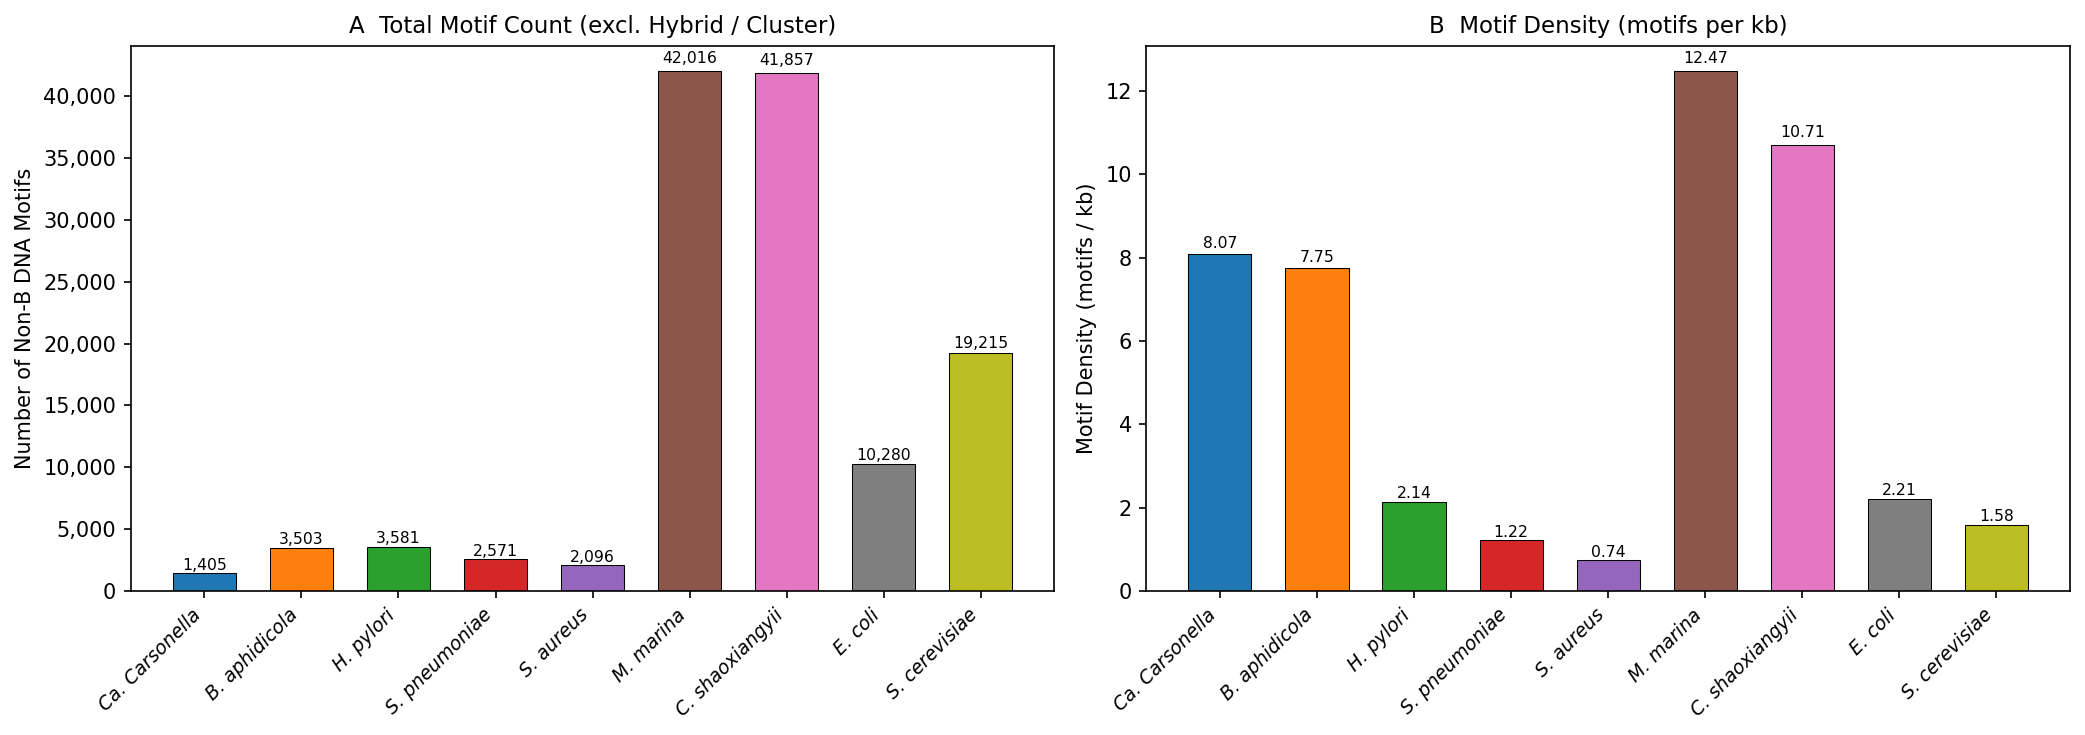

Figure 1 saved.


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x     = np.arange(len(SHORT))
width = 0.65
pal   = sns.color_palette("tab10", n_colors=len(SHORT))

# 1A – absolute counts
counts = STATS["Motifs (excl. Hybrid/Cluster)"].values
bars   = axes[0].bar(x, counts, width, color=pal, edgecolor="k", linewidth=0.5)
axes[0].set_xticks(x)
axes[0].set_xticklabels(SHORT, rotation=45, ha="right", fontstyle="italic", fontsize=9)
axes[0].set_ylabel("Number of Non-B DNA Motifs")
axes[0].set_title("A  Total Motif Count (excl. Hybrid / Cluster)")
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda v, _: f"{int(v):,}"))
for bar in bars:
    h = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, h*1.01, f"{int(h):,}",
                 ha="center", va="bottom", fontsize=7.5, rotation=0)

# 1B – density
density = STATS["Motif Density"].values
bars2   = axes[1].bar(x, density, width, color=pal, edgecolor="k", linewidth=0.5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(SHORT, rotation=45, ha="right", fontstyle="italic", fontsize=9)
axes[1].set_ylabel("Motif Density (motifs / kb)")
axes[1].set_title("B  Motif Density (motifs per kb)")
for bar in bars2:
    h = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, h*1.01, f"{h:.2f}",
                 ha="center", va="bottom", fontsize=7.5)

plt.tight_layout()
plt.savefig("Figure1_Motif_Counts_and_Density.pdf", bbox_inches="tight")
plt.savefig("Figure1_Motif_Counts_and_Density.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 1 saved.")


## Cell 4 · Table 2 & Figure 2 — Non-B DNA Class Distribution (Raw Counts)

**Table 2** presents the absolute count of each Non-B DNA class across all nine genomes.
**Figure 2** visualises these counts as a grouped-bar chart.

In [4]:
# Build class-count matrix
class_counts = {}
for org in ORGANISMS:
    vc = MOTIFS[org]["Class"].value_counts()
    class_counts[SHORT_NAMES.get(org, org)] = vc

CLASS_TABLE_RAW = pd.DataFrame(class_counts, index=ALL_CLASSES).T.fillna(0).astype(int)
print("Table 2. Non-B DNA Class Counts per Genome")
print("=" * 100)
display(CLASS_TABLE_RAW)


Table 2. Non-B DNA Class Counts per Genome


Curved_DNA  A-philic_DNA  Cruciform  Slipped_DNA  Triplex  \
Ca. Carsonella         1093             0        270           12       18   
B. aphidicola          2671             1        583          104      127   
H. pylori              1041            55        476           69       20   
S. pneumoniae           533             7        852           35        5   
S. aureus               697            68        879           48       15   
M. marina                 3          1954       5207          135        3   
C. shaoxiangyii           0          1524       4947          338        4   
E. coli                 521            67       1830           19        8   
S. cerevisiae          8440           239       2632         1224      629   

                 Z-DNA  R-Loop  G-Quadruplex  i-Motif  Hybrid  \
Ca. Carsonella       0       2            10        0      61   
B. aphidicola        0       1            16        0     156   
H. pylori           23     773          1102       22      81   
S. pneumoniae       10     114          1014        1      19   
S. aureus            7      41           341        0      20   
M. marina         7835    1375         25104      400    2563   
C. shaoxiangyii   8740    1621         24198      485    1971   
E. coli            900     783          6126       26     108   
S. cerevisiae      106     904          5018       23     381   

                 Non-B_DNA_Clusters  
Ca. Carsonella                   26  
B. aphidicola                   176  
H. pylori                       109  
S. pneumoniae                    17  
S. aureus                        22  
M. marina                      4530  
C. shaoxiangyii                4543  
E. coli                         144  
S. cerevisiae                   656

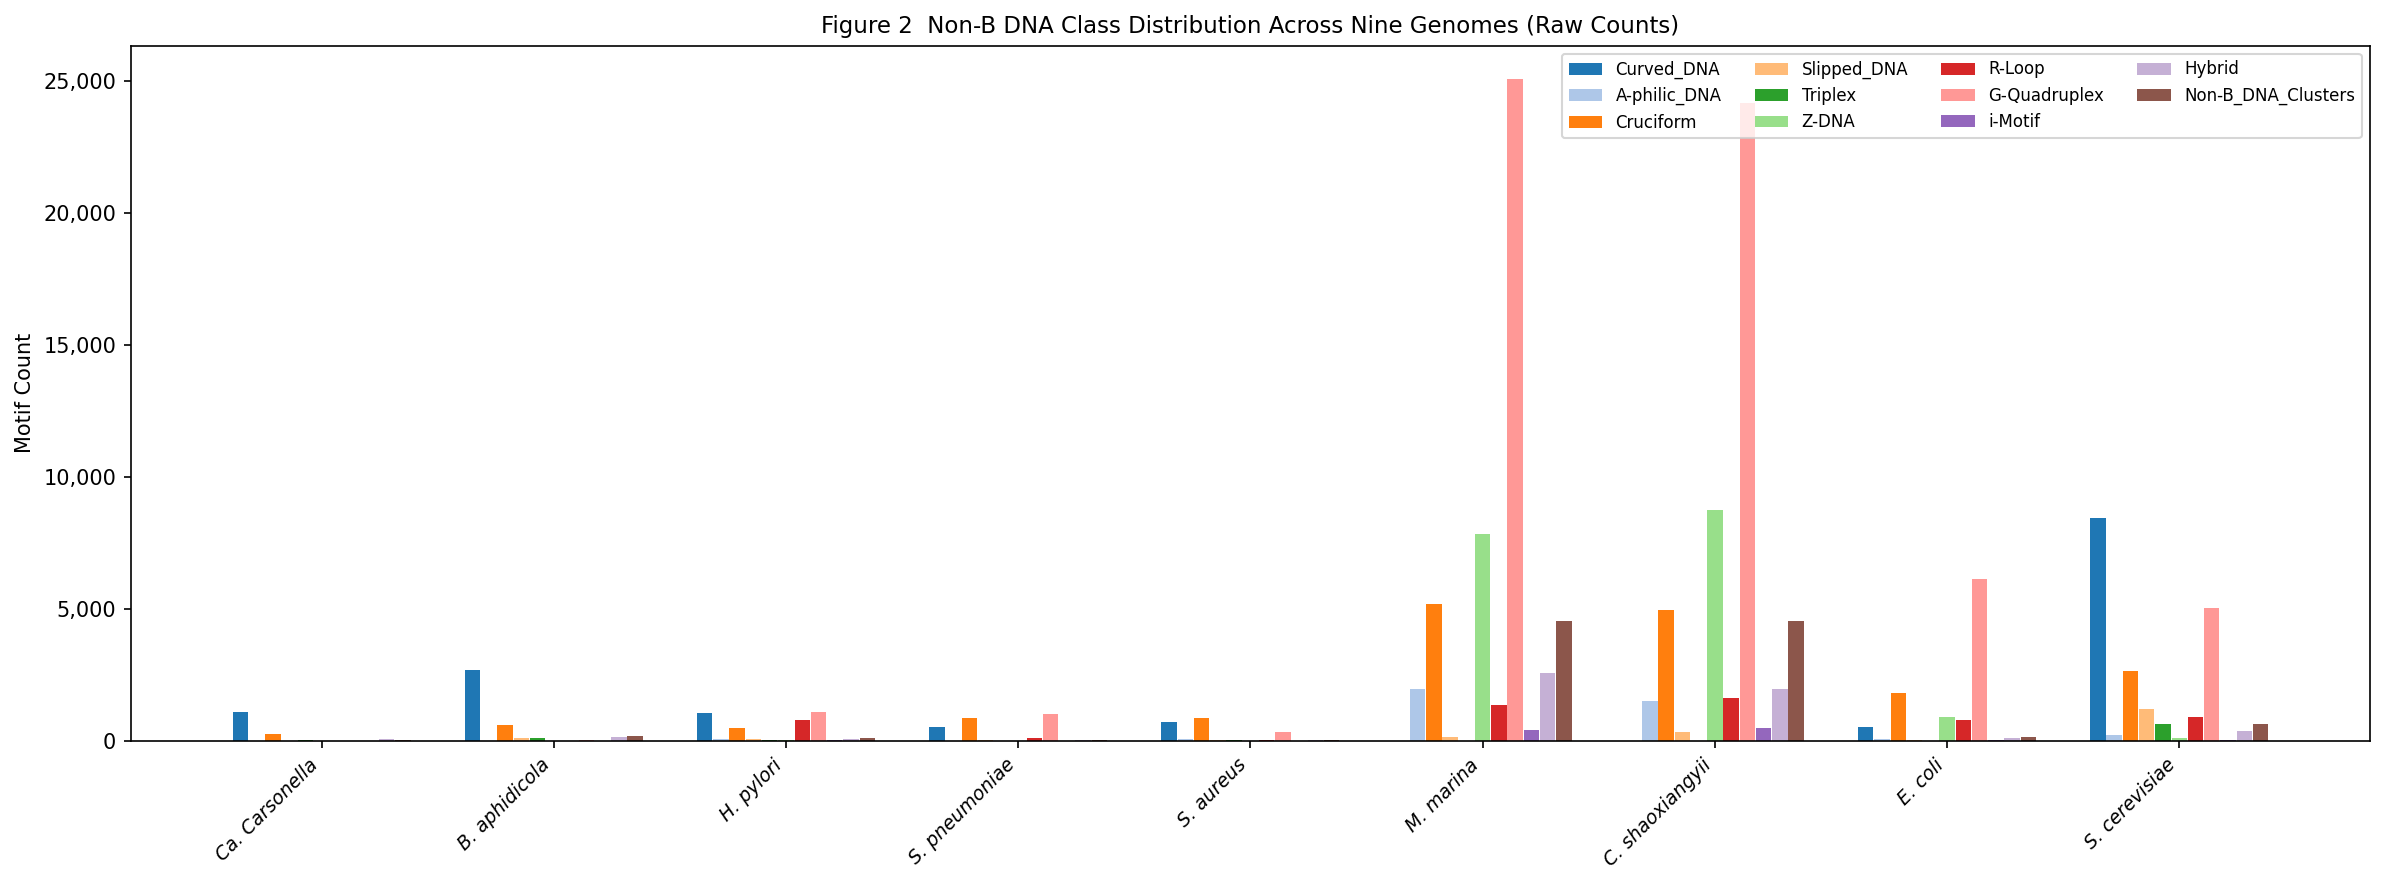

Figure 2 saved.


In [5]:
fig, ax = plt.subplots(figsize=(16, 6))

n_org   = len(SHORT)
n_cls   = len(ALL_CLASSES)
x       = np.arange(n_org)
w       = 0.07
offsets = np.linspace(-(n_cls - 1)*w/2, (n_cls - 1)*w/2, n_cls)

for i, cls in enumerate(ALL_CLASSES):
    vals = CLASS_TABLE_RAW[cls].values
    ax.bar(x + offsets[i], vals, w * 0.95, label=cls,
           color=CLASS_COLORS[cls], edgecolor="none")

ax.set_xticks(x)
ax.set_xticklabels(SHORT, rotation=45, ha="right", fontstyle="italic", fontsize=9)
ax.set_ylabel("Motif Count")
ax.set_title("Figure 2  Non-B DNA Class Distribution Across Nine Genomes (Raw Counts)")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda v, _: f"{int(v):,}"))
ax.legend(ncol=4, fontsize=8, loc="upper right", framealpha=0.8)
plt.tight_layout()
plt.savefig("Figure2_Class_Raw_Counts.pdf",  bbox_inches="tight")
plt.savefig("Figure2_Class_Raw_Counts.png",  dpi=200, bbox_inches="tight")
plt.show()
print("Figure 2 saved.")


## Cell 5 · Table 3 & Figure 3 — Class Density Normalised per Megabase

To account for genome-size differences, **Table 3** expresses each class count
as motifs per Mb.  **Figure 3** presents the same data as a heatmap.

In [6]:
genome_sizes_mb = STATS["Genome Length"].values / 1e6

CLASS_TABLE_NORM = CLASS_TABLE_RAW.copy().astype(float)
for i, sn in enumerate(CLASS_TABLE_NORM.index):
    CLASS_TABLE_NORM.iloc[i] /= genome_sizes_mb[i]

print("Table 3. Non-B DNA Class Density (motifs / Mb) — sorted by organism")
display(CLASS_TABLE_NORM.round(1))


Table 3. Non-B DNA Class Density (motifs / Mb) — sorted by organism


Curved_DNA  A-philic_DNA  Cruciform  Slipped_DNA  Triplex  \
Ca. Carsonella       6281.1           0.0     1551.6         69.0    103.4   
B. aphidicola        5908.3           2.2     1289.6        230.0    280.9   
H. pylori             621.9          32.9      284.3         41.2     11.9   
S. pneumoniae         252.5           3.3      403.6         16.6      2.4   
S. aureus             247.0          24.1      311.6         17.0      5.3   
M. marina               0.9         579.8     1545.0         40.1      0.9   
C. shaoxiangyii         0.0         389.8     1265.4         86.5      1.0   
E. coli               112.2          14.4      394.3          4.1      1.7   
S. cerevisiae         694.2          19.7      216.5        100.7     51.7   

                  Z-DNA  R-Loop  G-Quadruplex  i-Motif  Hybrid  \
Ca. Carsonella      0.0    11.5          57.5      0.0   350.5   
B. aphidicola       0.0     2.2          35.4      0.0   345.1   
H. pylori          13.7   461.8         658.3     13.1    48.4   
S. pneumoniae       4.7    54.0         480.3      0.5     9.0   
S. aureus           2.5    14.5         120.9      0.0     7.1   
M. marina        2324.7   408.0        7448.7    118.7   760.5   
C. shaoxiangyii  2235.7   414.6        6189.8    124.1   504.2   
E. coli           193.9   168.7        1319.8      5.6    23.3   
S. cerevisiae       8.7    74.4         412.8      1.9    31.3   

                 Non-B_DNA_Clusters  
Ca. Carsonella                149.4  
B. aphidicola                 389.3  
H. pylori                      65.1  
S. pneumoniae                   8.1  
S. aureus                       7.8  
M. marina                    1344.1  
C. shaoxiangyii              1162.1  
E. coli                        31.0  
S. cerevisiae                  54.0

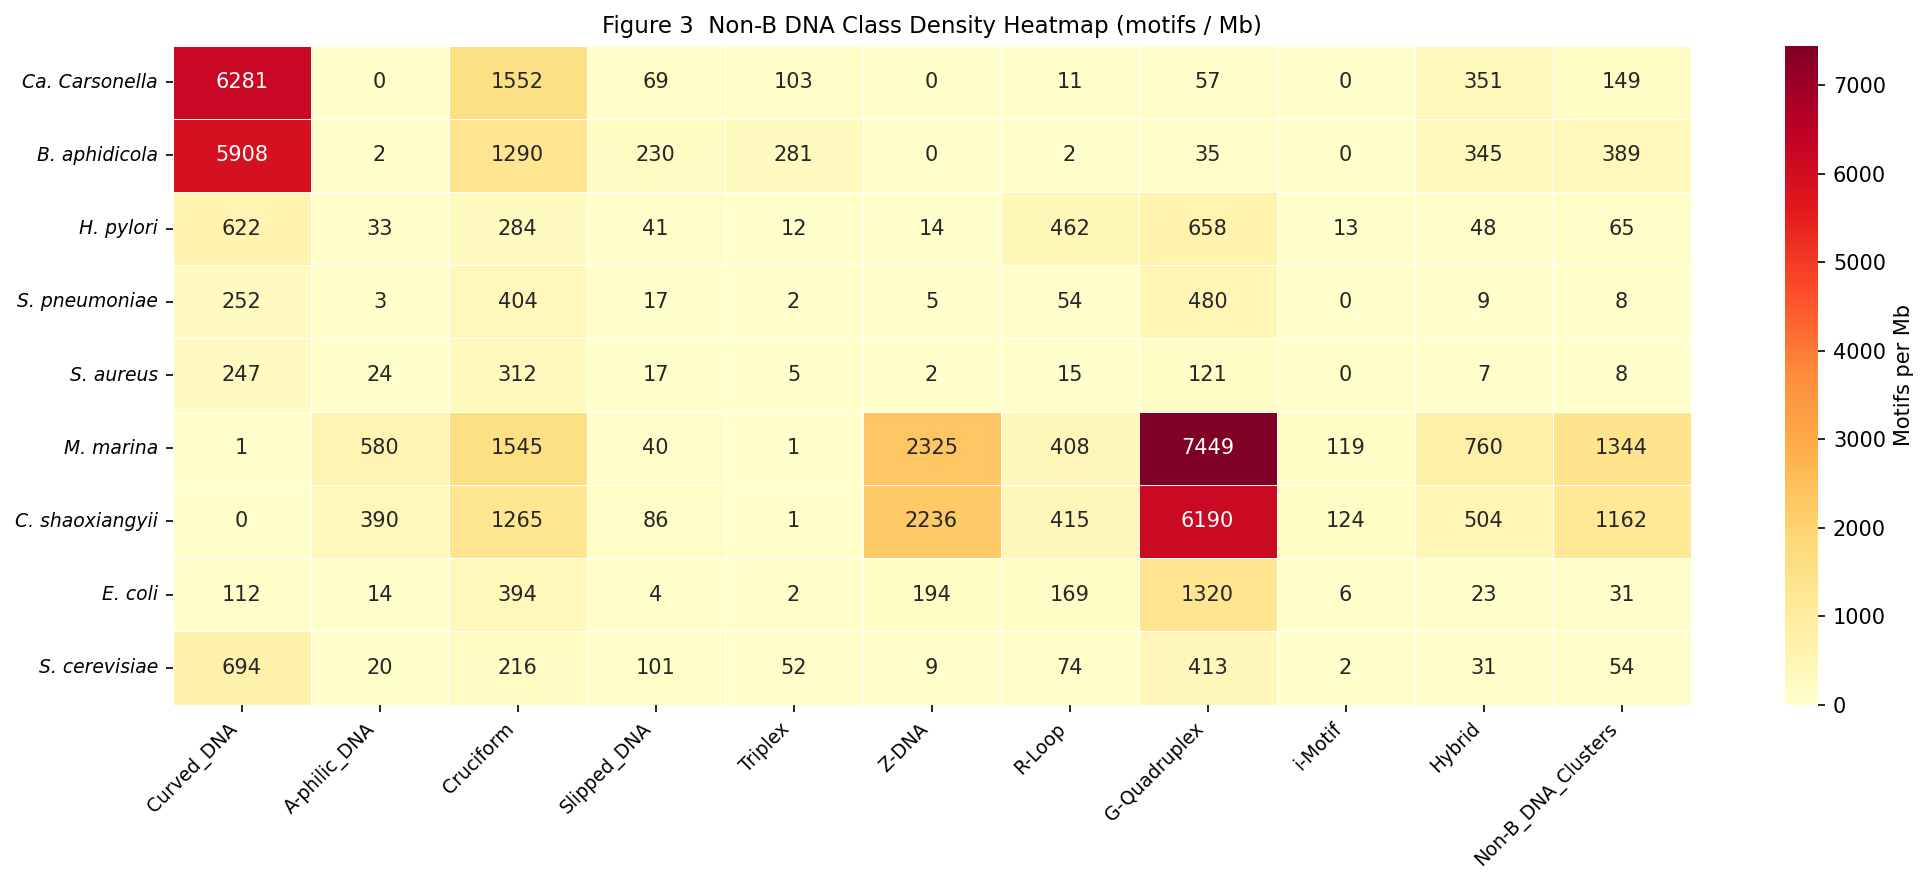

Figure 3 saved.


In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Drop columns that are zero everywhere for clarity
nonzero_cls = CLASS_TABLE_NORM.columns[(CLASS_TABLE_NORM > 0).any(axis=0)]
heat_data   = CLASS_TABLE_NORM[nonzero_cls]

sns.heatmap(
    heat_data,
    annot=True, fmt=".0f", linewidths=0.4, linecolor="white",
    cmap="YlOrRd", cbar_kws={"label": "Motifs per Mb"},
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), fontstyle="italic", fontsize=9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax.set_title("Figure 3  Non-B DNA Class Density Heatmap (motifs / Mb)")
plt.tight_layout()
plt.savefig("Figure3_Class_Density_Heatmap.pdf", bbox_inches="tight")
plt.savefig("Figure3_Class_Density_Heatmap.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 3 saved.")


## Cell 6 · Figure 4 — Proportional Class Composition (Stacked Bar)

**Figure 4** shows the *fractional* contribution of each Non-B DNA class to the
total motif repertoire, revealing the dominant structural class in each genome.

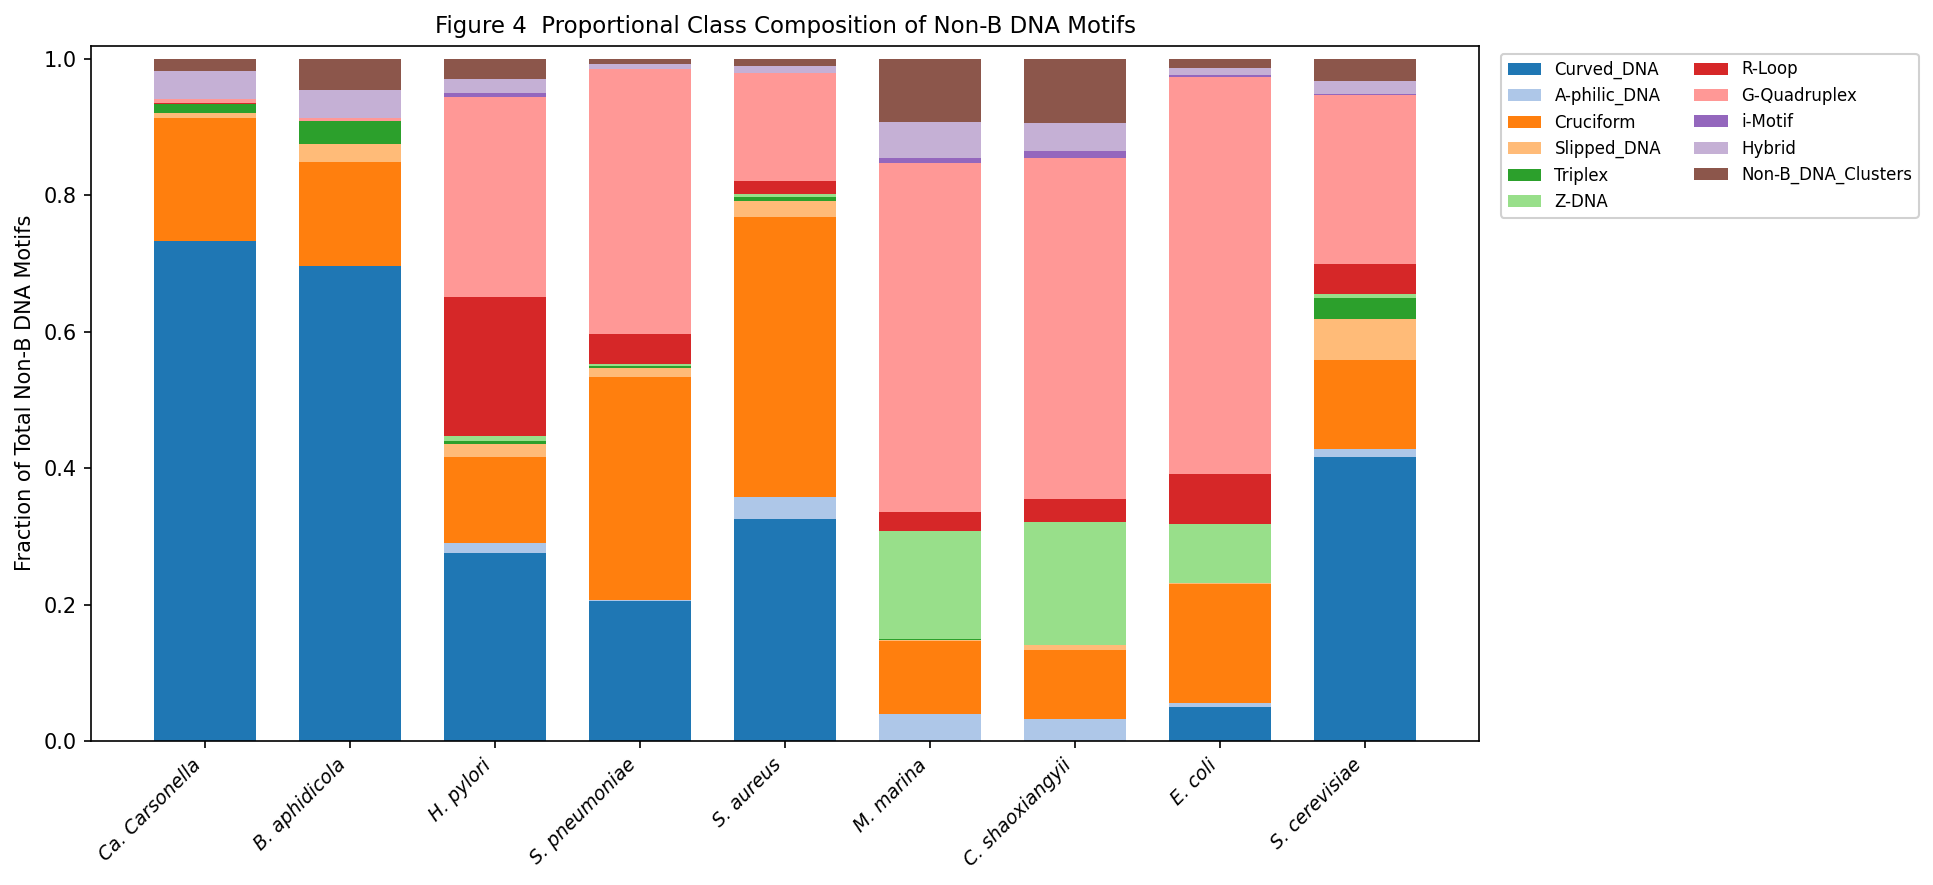

Figure 4 saved.


In [8]:
# Use counts including Hybrid / Cluster for proportions
class_prop = CLASS_TABLE_RAW.copy().astype(float)
row_sums   = class_prop.sum(axis=1)
for col in class_prop.columns:
    class_prop[col] /= row_sums

fig, ax = plt.subplots(figsize=(13, 6))
bottom  = np.zeros(len(SHORT))
for cls in ALL_CLASSES:
    vals = class_prop[cls].values if cls in class_prop.columns else np.zeros(len(SHORT))
    ax.bar(np.arange(len(SHORT)), vals, 0.7, bottom=bottom,
           label=cls, color=CLASS_COLORS[cls], edgecolor="none")
    bottom += vals

ax.set_xticks(np.arange(len(SHORT)))
ax.set_xticklabels(SHORT, rotation=45, ha="right", fontstyle="italic", fontsize=9)
ax.set_ylabel("Fraction of Total Non-B DNA Motifs")
ax.set_title("Figure 4  Proportional Class Composition of Non-B DNA Motifs")
ax.set_ylim(0, 1.02)
ax.legend(ncol=2, fontsize=8, bbox_to_anchor=(1.01, 1), loc="upper left", framealpha=0.9)
plt.tight_layout()
plt.savefig("Figure4_Class_Proportions_Stacked.pdf", bbox_inches="tight")
plt.savefig("Figure4_Class_Proportions_Stacked.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 4 saved.")


## Cell 7 · Table 4 — Subclass Distribution Across Genomes

**Table 4** shows the count of every detected Non-B DNA *subclass* per genome,
providing single-nucleotide structural resolution beyond the class level.

In [9]:
subclass_counts = {}
for org in ORGANISMS:
    vc = MOTIFS[org]["Subclass"].value_counts()
    subclass_counts[SHORT_NAMES.get(org, org)] = vc

SUBCLASS_TABLE = pd.DataFrame(subclass_counts).T.fillna(0).astype(int)
# Keep only subclasses present in at least one genome
SUBCLASS_TABLE = SUBCLASS_TABLE.loc[:, (SUBCLASS_TABLE > 0).any(axis=0)]

# Sort subclasses by total count
col_order = SUBCLASS_TABLE.sum(axis=0).sort_values(ascending=False).index
SUBCLASS_TABLE = SUBCLASS_TABLE[col_order]

print("Table 4. Non-B DNA Subclass Counts per Genome  (top 20 subclasses)")
print("=" * 120)
display(SUBCLASS_TABLE.iloc[:, :20])


Table 4. Non-B DNA Subclass Counts per Genome  (top 20 subclasses)


Subclass         Two-tetrad weak PQS  Cruciform forming IRs  Z-DNA  \
Ca. Carsonella                     9                    270      0   
B. aphidicola                     15                    583      0   
H. pylori                        912                    476     22   
S. pneumoniae                    995                    852     10   
S. aureus                        337                    879      7   
M. marina                      21157                   5207   7428   
C. shaoxiangyii                20456                   4947   8552   
E. coli                         5823                   1830    892   
S. cerevisiae                   4745                   2632    105   

Subclass         Local Curvature  Mixed_Cluster_3_classes  \
Ca. Carsonella               976                       23   
B. aphidicola               2406                      135   
H. pylori                    420                       82   
S. pneumoniae                123                       17   
S. aureus                     97                       19   
M. marina                      0                     2917   
C. shaoxiangyii                0                     2991   
E. coli                      224                      114   
S. cerevisiae               6350                      404   

Subclass         R-loop formation sites  Global Curvature  Bulged G4  \
Ca. Carsonella                        2               117          0   
B. aphidicola                         1               265          1   
H. pylori                           773               621         22   
S. pneumoniae                       114               410          2   
S. aureus                            41               600          2   
M. marina                          1375                 3       2271   
C. shaoxiangyii                    1621                 0       1814   
E. coli                             783               297        126   
S. cerevisiae                       904              2090         80   

Subclass         A-philic DNA  Mixed_Cluster_4_classes  \
Ca. Carsonella              0                        3   
B. aphidicola               1                       40   
H. pylori                  55                       25   
S. pneumoniae               7                        0   
S. aureus                  68                        3   
M. marina                1954                     1286   
C. shaoxiangyii          1524                     1258   
E. coli                    67                       29   
S. cerevisiae             239                      201   

Subclass         Intramolecular G-triplex  Extended-loop canonical  \
Ca. Carsonella                          1                        0   
B. aphidicola                           0                        0   
H. pylori                             108                       54   
S. pneumoniae                          14                        3   
S. aureus                               2                        0   
M. marina                             941                      625   
C. shaoxiangyii                       987                      803   
E. coli                               144                       23   
S. cerevisiae                         137                       52   

Subclass         Direct Repeat  Canonical i-motif  \
Ca. Carsonella              11                  0   
B. aphidicola               79                  0   
H. pylori                   54                 16   
S. pneumoniae               34                  1   
S. aureus                   48                  0   
M. marina                  115                398   
C. shaoxiangyii            306                484   
E. coli                     16                 24   
S. cerevisiae              592                 22   

Subclass         Cruciform_G-Quadruplex_Overlap  \
Ca. Carsonella                                0   
B. aphidicola                                 0   
H

In [10]:
# Full subclass table as an Excel file
SUBCLASS_TABLE.to_excel("Table4_Subclass_Distribution.xlsx")
print("Full subclass distribution saved to Table4_Subclass_Distribution.xlsx")
print(f"Total unique subclasses across all genomes: {SUBCLASS_TABLE.shape[1]}")


Full subclass distribution saved to Table4_Subclass_Distribution.xlsx
Total unique subclasses across all genomes: 81


## Cell 7b · Table 4b — 22-Subclass Detailed Analysis (Per-Genome Counts & Densities)

The **22 canonical subclasses** comprise 20 pure structural variants (2 Curved DNA, 1 A-philic, 1 Cruciform, 3 Slipped, 1 Triplex, 2 Z-DNA, 1 R-Loop, 7 G-Quadruplex, 2 i-Motif) plus the 2 dominant cluster composites (3-class and 4-class clusters). This section provides genome-level counts and density-normalised data for all 22 subclasses, enabling a direct structural comparison across domains of life.

In [11]:
# ── Build 22-subclass count matrix ────────────────────────────────────────────
sc22_counts = {}
for org in ORGANISMS:
    sn = SHORT_NAMES.get(org, org)
    vc = MOTIFS[org]["Subclass"].value_counts()
    sc22_counts[sn] = {s: int(vc.get(s, 0)) for s in CANON_22}

SC22 = pd.DataFrame(sc22_counts).T  # shape: organisms × 22 subclasses
SC22 = SC22[CANON_22]  # enforce column order

# Density per Mb
SC22_DENS = SC22.copy().astype(float)
for i, sn in enumerate(SC22_DENS.index):
    SC22_DENS.iloc[i] /= genome_sizes_mb[i]

print("Table 4b. 22-Subclass Raw Counts per Genome")
print("=" * 120)
display(SC22)

print("\nTable 4c. 22-Subclass Density (per Mb) per Genome")
print("=" * 120)
display(SC22_DENS.round(2))

# Save
SC22.to_excel("Table4b_22Subclass_Counts.xlsx")
SC22_DENS.round(2).to_excel("Table4c_22Subclass_Density_perMb.xlsx")
print("\nSaved Table4b and Table4c.")

Table 4b. 22-Subclass Raw Counts per Genome


Local Curvature  Global Curvature  A-philic DNA  \
Ca. Carsonella               976               117             0   
B. aphidicola               2406               265             1   
H. pylori                    420               621            55   
S. pneumoniae                123               410             7   
S. aureus                     97               600            68   
M. marina                      0                 3          1954   
C. shaoxiangyii                0                 0          1524   
E. coli                      224               297            67   
S. cerevisiae               6350              2090           239   

                 Cruciform forming IRs  Direct Repeat  STR  Sticky DNA  \
Ca. Carsonella                     270             11    1           0   
B. aphidicola                      583             79   25           1   
H. pylori                          476             54   15           6   
S. pneumoniae                      852             34    1           1   
S. aureus                          879             48    0           5   
M. marina                         5207            115   20           1   
C. shaoxiangyii                   4947            306   32           0   
E. coli                           1830             16    3           3   
S. cerevisiae                     2632            592  632         189   

                 Triplex  Z-DNA  eGZ  ...  Bulged G4  \
Ca. Carsonella        18      0    0  ...          0   
B. aphidicola        126      0    0  ...          1   
H. pylori             14     22    1  ...         22   
S. pneumoniae          4     10    0  ...          2   
S. aureus             10      7    0  ...          2   
M. marina              2   7428  407  ...       2271   
C. shaoxiangyii        4   8552  188  ...       1814   
E. coli                5    892    8  ...        126   
S. cerevisiae        440    105    1  ...         80   

                 Intramolecular G-triplex  Extended-loop canonical  \
Ca. Carsonella                          1                        0   
B. aphidicola                           0                        0   
H. pylori                             108                       54   
S. pneumoniae                          14                        3   
S. aureus                               2                        0   
M. marina                             941                      625   
C. shaoxiangyii                       987                      803   
E. coli                               144                       23   
S. cerevisiae                         137                       52   

                 Canonical intramolecular G4  Higher-order G4 array/G4-wire  \
Ca. Carsonella                             0                              0   
B. aphidicola                              0                              0   
H. pylori                                  6                              0   
S. pneumoniae                              0                              0   
S. aureus                                  0                              0   
M. marina                                 90                             15   
C. shaoxiangyii                          102                             20   
E. coli                                   10                              0   
S. cerevisiae                              4                              0   

                 Stacked G4  Canonical i-motif  AC-motif  \
Ca. Carsonella            0                  0         0   
B. aphidicola             0                  0         0   
H. pylori                 0                 16         6   
S. pneumoniae             0                  1         0   
S. aureus                 0                  0         0   
M. marina                 5                398         2   
C. shaoxiangyii          16                484         1   
E. coli                   0                 24         2   
S.


Table 4c. 22-Subclass Density (per Mb) per Genome


Local Curvature  Global Curvature  A-philic DNA  \
Ca. Carsonella           5608.74            672.36          0.00   
B. aphidicola            5322.09            586.18          2.21   
H. pylori                 250.89            370.97         32.86   
S. pneumoniae              58.27            194.22          3.32   
S. aureus                  34.38            212.66         24.10   
M. marina                   0.00              0.89        579.77   
C. shaoxiangyii             0.00              0.00        389.83   
E. coli                    48.26             63.99         14.43   
S. cerevisiae             522.33            171.92         19.66   

                 Cruciform forming IRs  Direct Repeat    STR  Sticky DNA  \
Ca. Carsonella                 1551.60          63.21   5.75        0.00   
B. aphidicola                  1289.60         174.75  55.30        2.21   
H. pylori                       284.35          32.26   8.96        3.58   
S. pneumoniae                   403.61          16.11   0.47        0.47   
S. aureus                       311.55          17.01   0.00        1.77   
M. marina                      1544.98          34.12   5.93        0.30   
C. shaoxiangyii                1265.42          78.27   8.19        0.00   
E. coli                         394.26           3.45   0.65        0.65   
S. cerevisiae                   216.50          48.70  51.99       15.55   

                 Triplex    Z-DNA     eGZ  ...  Bulged G4  \
Ca. Carsonella    103.44     0.00    0.00  ...       0.00   
B. aphidicola     278.71     0.00    0.00  ...       2.21   
H. pylori           8.36    13.14    0.60  ...      13.14   
S. pneumoniae       1.89     4.74    0.00  ...       0.95   
S. aureus           3.54     2.48    0.00  ...       0.71   
M. marina           0.59  2203.98  120.76  ...     673.83   
C. shaoxiangyii     1.02  2187.57   48.09  ...     464.01   
E. coli             1.08   192.17    1.72  ...      27.15   
S. cerevisiae      36.19     8.64    0.08  ...       6.58   

                 Intramolecular G-triplex  Extended-loop canonical  \
Ca. Carsonella                       5.75                     0.00   
B. aphidicola                        0.00                     0.00   
H. pylori                           64.52                    32.26   
S. pneumoniae                        6.63                     1.42   
S. aureus                            0.71                     0.00   
M. marina                          279.21                   185.44   
C. shaoxiangyii                    252.47                   205.40   
E. coli                             31.02                     4.96   
S. cerevisiae                       11.27                     4.28   

                 Canonical intramolecular G4  Higher-order G4 array/G4-wire  \
Ca. Carsonella                          0.00                           0.00   
B. aphidicola                           0.00                           0.00   
H. pylori                               3.58                           0.00   
S. pneumoniae                           0.00                           0.00   
S. aureus                               0.00                           0.00   
M. marina                              26.70                           4.45   
C. shaoxiangyii                        26.09                           5.12   
E. coli                                 2.15                           0.00   
S. cerevisiae                           0.33                           0.00   

                 Stacked G4  Canonical i-motif  AC-motif  \
Ca. Carsonella         0.00               0.00      0.00   
B. aphidicola          0.00               0.00      0.00   
H. pylori              0.00               9.56      3.58   
S. pneumoniae          0.00               0.47      0.00   
S. aureus              0.00               0.00      0.00   
M. marina              1.48             118.09      0.59   
C. shaoxiangyii        4.09             123.81      


Saved Table4b and Table4c.


## Cell 7c · Figure 5b — 22-Subclass Density Heatmap (per Mb)

Each row = one genome (size-ordered); each column = one of the 22 canonical subclasses.
Colour encodes log₁₀(density per Mb + 0.01) to span the large dynamic range.
Column annotations show parent class.

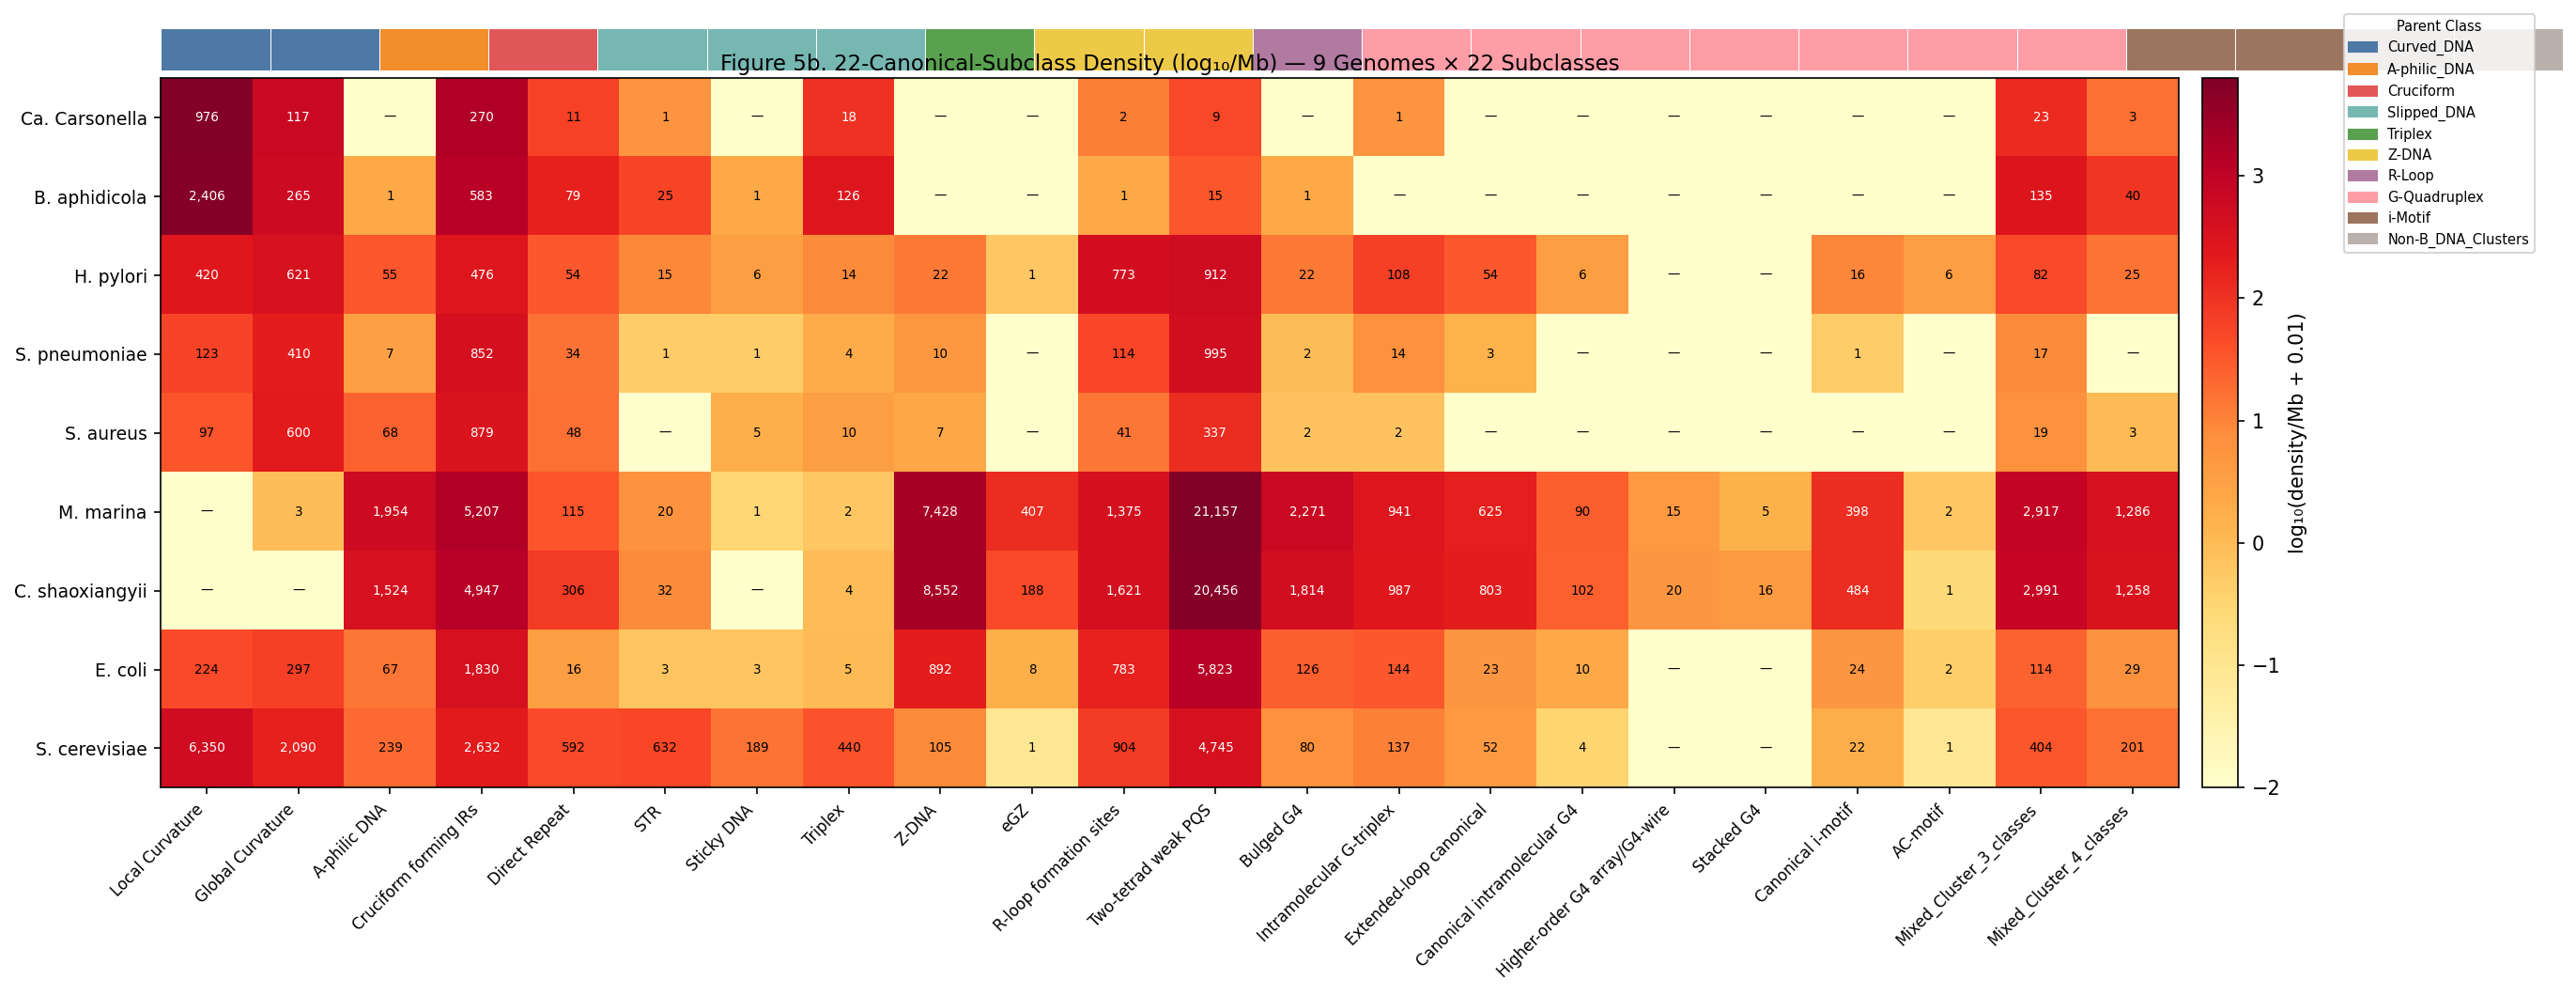

Figure 5b saved.


In [12]:
import matplotlib.gridspec as gridspec

# log-scale for visual clarity
heat22 = np.log10(SC22_DENS + 0.01)

# Class-colour header row
class_palette = {
    "Curved_DNA": "#4e79a7", "A-philic_DNA": "#f28e2b", "Cruciform": "#e15759",
    "Slipped_DNA": "#76b7b2", "Triplex": "#59a14f", "Z-DNA": "#edc948",
    "R-Loop": "#b07aa1", "G-Quadruplex": "#ff9da7", "i-Motif": "#9c755f",
    "Non-B_DNA_Clusters": "#bab0ac",
}

fig = plt.figure(figsize=(22, 7))
gs  = gridspec.GridSpec(2, 1, height_ratios=[0.06, 1], hspace=0.02)

# Class-colour header
ax_head = fig.add_subplot(gs[0])
for j, sc in enumerate(CANON_22):
    cls = C22_CLASS[sc]
    ax_head.add_patch(plt.Rectangle((j, 0), 1, 1,
        color=class_palette.get(cls, "#cccccc"), ec="white", lw=0.5))
ax_head.set_xlim(0, 22); ax_head.set_ylim(0, 1)
ax_head.axis("off")

# Heatmap
ax_hm = fig.add_subplot(gs[1])
im = ax_hm.imshow(heat22.values, aspect="auto", cmap="YlOrRd",
                  vmin=heat22.values.min(), vmax=heat22.values.max())
ax_hm.set_xticks(range(22))
ax_hm.set_xticklabels(CANON_22, rotation=45, ha="right", fontsize=8)
ax_hm.set_yticks(range(len(SHORT)))
ax_hm.set_yticklabels(SHORT, fontsize=9)

# Annotate with actual counts
for r in range(len(SHORT)):
    for c in range(22):
        val = SC22.iloc[r, c]
        ax_hm.text(c, r, f"{val:,}" if val >= 10 else (str(val) if val > 0 else "—"),
                   ha="center", va="center", fontsize=6.5,
                   color="white" if heat22.iloc[r, c] > 2 else "black")

plt.colorbar(im, ax=ax_hm, pad=0.01, label="log₁₀(density/Mb + 0.01)")

# Legend for class colours
handles = [mpatches.Patch(color=v, label=k) for k, v in class_palette.items()
           if k in C22_CLASS.values()]
ax_hm.legend(handles=handles, loc="upper right", bbox_to_anchor=(1.18, 1.1),
             fontsize=7, title="Parent Class", title_fontsize=7)

ax_hm.set_title("Figure 5b. 22-Canonical-Subclass Density (log₁₀/Mb) — 9 Genomes × 22 Subclasses",
                fontsize=11, pad=4)
plt.tight_layout()
plt.savefig("Figure5b_22Subclass_Density_Heatmap.pdf", bbox_inches="tight")
plt.savefig("Figure5b_22Subclass_Density_Heatmap.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 5b saved.")

## Cell 8 · Figure 5 — Subclass Density Heatmap (Top 25 Subclasses)

**Figure 5** is a heatmap of the 25 most prevalent Non-B DNA subclasses,
expressed as density (per Mb) to enable cross-genome comparison.

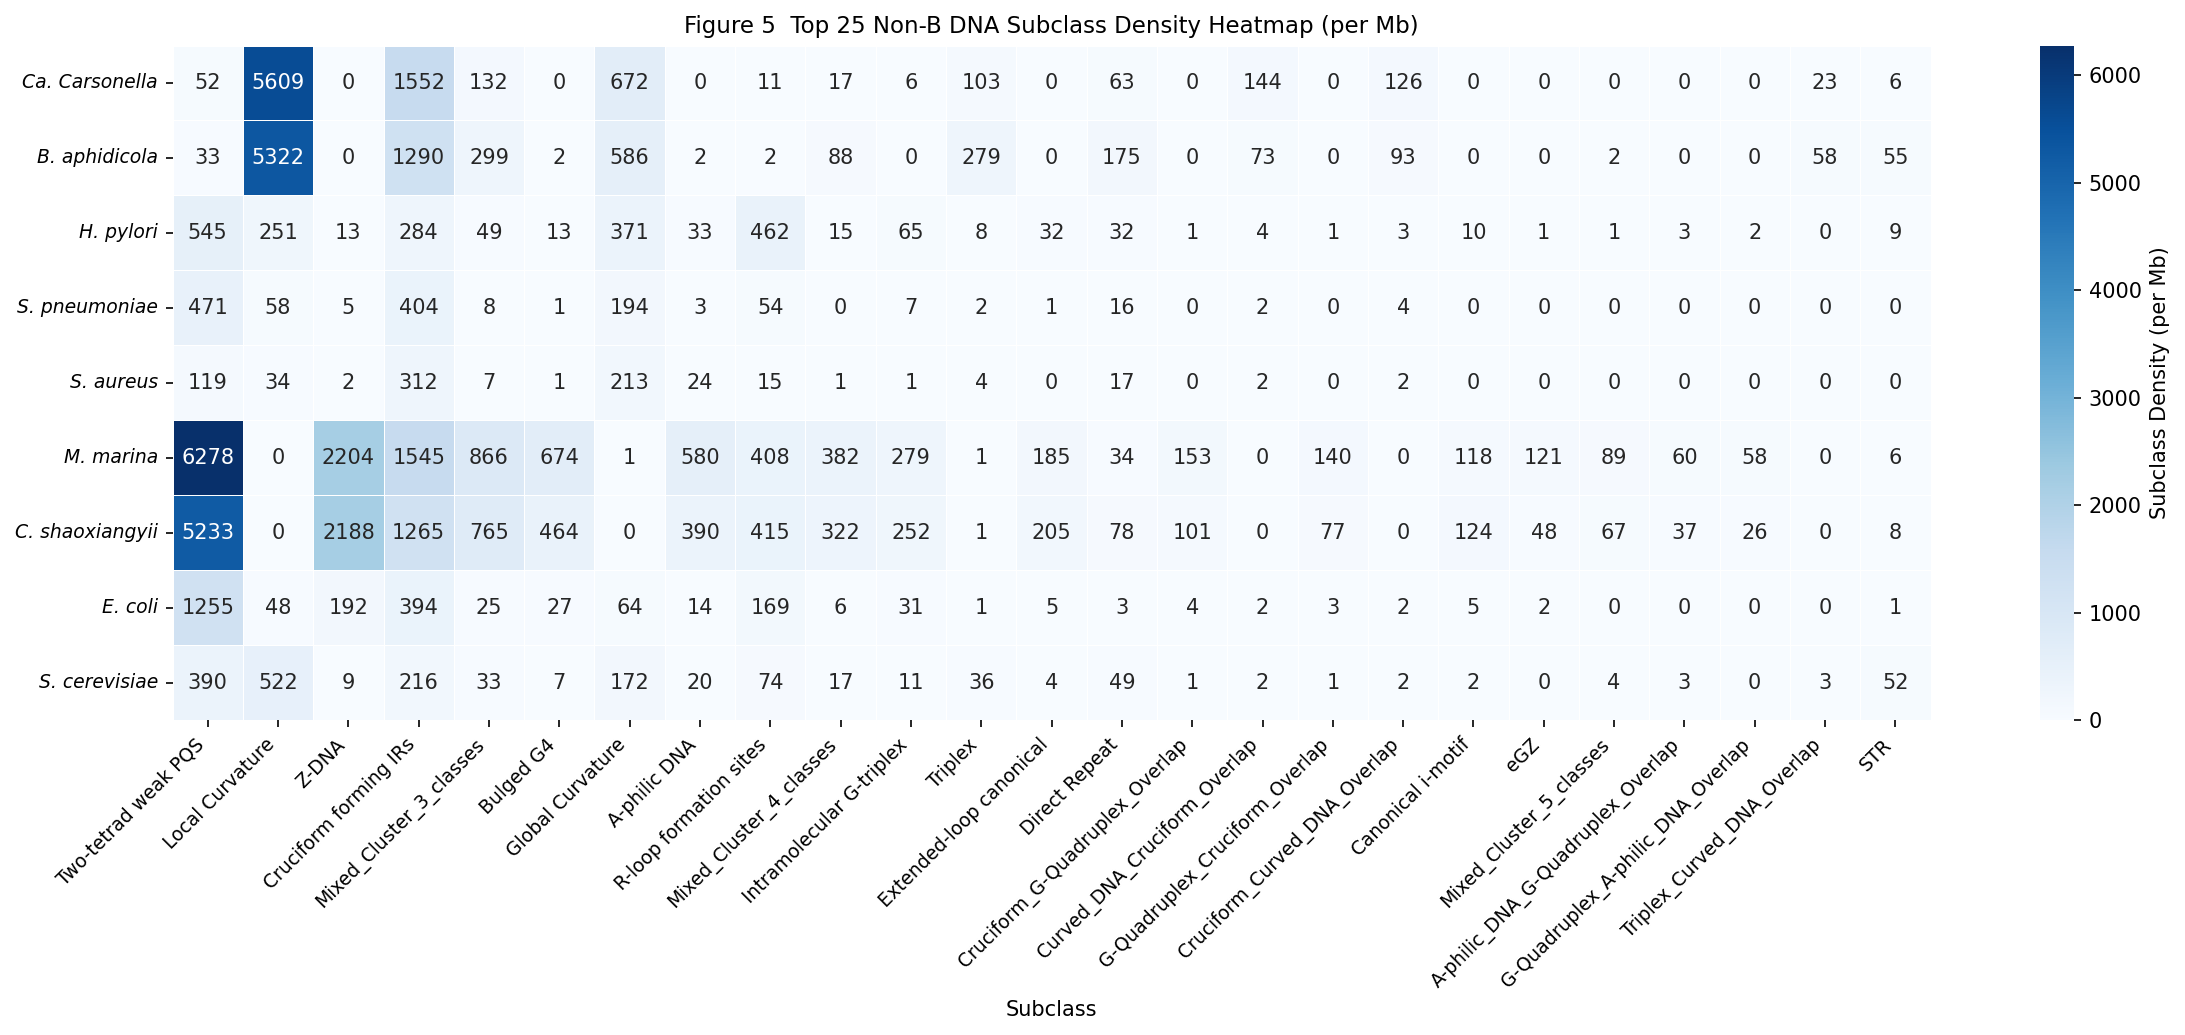

Figure 5 saved.


In [13]:
# Normalise to per-Mb
SUBCLASS_NORM = SUBCLASS_TABLE.copy().astype(float)
for i, sn in enumerate(SUBCLASS_NORM.index):
    SUBCLASS_NORM.iloc[i] /= genome_sizes_mb[i]

# Top 25 subclasses by max density in any organism
top25 = SUBCLASS_NORM.max(axis=0).nlargest(25).index
heat25 = SUBCLASS_NORM[top25]

fig, ax = plt.subplots(figsize=(16, 7))
sns.heatmap(
    heat25,
    annot=True, fmt=".0f", linewidths=0.3, linecolor="white",
    cmap="Blues", cbar_kws={"label": "Subclass Density (per Mb)"},
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), fontstyle="italic", fontsize=9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax.set_title("Figure 5  Top 25 Non-B DNA Subclass Density Heatmap (per Mb)")
plt.tight_layout()
plt.savefig("Figure5_Subclass_Heatmap.pdf", bbox_inches="tight")
plt.savefig("Figure5_Subclass_Heatmap.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 5 saved.")


## Cell 9 · Table 5 & Figure 6 — Hybrid Region Analysis

**Hybrid regions** are genomic loci where two structurally distinct Non-B DNA
motifs overlap, implying cooperative or competitive structural potential.
**Table 5** lists counts and coverage; **Figure 6** visualises hybrid composition.

In [14]:
# Extract hybrid entries from motifs data
HYBRID_TYPES = {}
for org in ORGANISMS:
    df_h = MOTIFS[org][MOTIFS[org]["Class"] == "Hybrid"]
    HYBRID_TYPES[SHORT_NAMES.get(org, org)] = df_h["Subclass"].value_counts()

HYBRID_TABLE = pd.DataFrame(HYBRID_TYPES).T.fillna(0).astype(int)
HYBRID_TABLE = HYBRID_TABLE.loc[:, (HYBRID_TABLE > 0).any(axis=0)]
col_order_h  = HYBRID_TABLE.sum(axis=0).sort_values(ascending=False).index
HYBRID_TABLE = HYBRID_TABLE[col_order_h]

# Summary stats from comprehensive CSV
tbl5_summary = STATS[["Short", "Hybrid Regions", "Hybrid Coverage", "GC_Percent"]].copy()
tbl5_summary.index = STATS["Short"]
tbl5_summary = tbl5_summary.drop(columns="Short")
tbl5_summary.columns = ["Hybrid Regions", "Hybrid Coverage (%)", "GC (%)"]
tbl5_summary["Hybrid Coverage (%)"] = tbl5_summary["Hybrid Coverage (%)"].apply(lambda x: f"{x:.4f}%")
tbl5_summary["Hybrid Regions"]  = tbl5_summary["Hybrid Regions"].apply(lambda x: f"{int(x):,}")
tbl5_summary["GC (%)"] = tbl5_summary["GC (%)"].apply(lambda x: f"{x:.2f}%")

# Hybrid density per Mb
hybrid_density = STATS["Hybrid Regions"].values / (STATS["Genome Length"].values / 1e6)

print("Table 5A. Hybrid Region Summary (with GC content)")
display(tbl5_summary)
print()
print("Table 5B. Hybrid Subtype Counts per Genome (top 15)")
display(HYBRID_TABLE.iloc[:, :15])

# ── GC vs. Hybrid density correlation ────────────────────────────────────────
r_hyb, p_hyb = stats.pearsonr(GC, hybrid_density)
print(f"\nPearson r(GC% vs Hybrid density/Mb) = {r_hyb:.3f}, p = {p_hyb:.4f}")


Table 5A. Hybrid Region Summary (with GC content)


Hybrid Regions Hybrid Coverage (%)  GC (%)
Short                                                     
Ca. Carsonella              61             0.9292%  17.63%
B. aphidicola              156             0.8994%  18.28%
H. pylori                   81             0.2456%  38.79%
S. pneumoniae               19             0.0417%  39.73%
S. aureus                   20             0.0282%  32.87%
M. marina                2,563            17.0972%  76.16%
C. shaoxiangyii          1,971            16.0085%  75.30%
E. coli                    108             0.3575%  50.79%
S. cerevisiae              381             0.1028%  38.15%


Table 5B. Hybrid Subtype Counts per Genome (top 15)


Subclass         Cruciform_G-Quadruplex_Overlap  \
Ca. Carsonella                                0   
B. aphidicola                                 0   
H. pylori                                     2   
S. pneumoniae                                 1   
S. aureus                                     0   
M. marina                                   515   
C. shaoxiangyii                             394   
E. coli                                      18   
S. cerevisiae                                 9   

Subclass         G-Quadruplex_Cruciform_Overlap  G-Quadruplex_R-Loop_Overlap  \
Ca. Carsonella                                0                            0   
B. aphidicola                                 0                            0   
H. pylori                                     2                            8   
S. pneumoniae                                 0                            0   
S. aureus                                     1                            0   
M. marina                                   471                          177   
C. shaoxiangyii                             301                          193   
E. coli                                      15                            9   
S. cerevisiae                                 8                           10   

Subclass         A-philic_DNA_G-Quadruplex_Overlap  \
Ca. Carsonella                                   0   
B. aphidicola                                    0   
H. pylori                                        5   
S. pneumoniae                                    0   
S. aureus                                        0   
M. marina                                      201   
C. shaoxiangyii                                145   
E. coli                                          2   
S. cerevisiae                                   40   

Subclass         G-Quadruplex_A-philic_DNA_Overlap  Cruciform_Z-DNA_Overlap  \
Ca. Carsonella                                   0                        0   
B. aphidicola                                    0                        0   
H. pylori                                        3                        0   
S. pneumoniae                                    0                        0   
S. aureus                                        0                        0   
M. marina                                      194                      176   
C. shaoxiangyii                                103                      117   
E. coli                                          0                        0   
S. cerevisiae                                    6                        0   

Subclass         Z-DNA_Cruciform_Overlap  G-Quadruplex_Z-DNA_Overlap  \
Ca. Carsonella                         0                           0   
B. aphidicola                          0                           0   
H. pylori                              0                           1   
S. pneumoniae                          0                           0   
S. aureus                              0                           0   
M. marina                            169                         143   
C. shaoxiangyii                      122                          91   
E. coli                                1                           6   
S. cerevisiae                          0                           0   

Subclass         Z-DNA_G-Quadruplex_Overlap  R-Loop_G-Quadruplex_Overlap  \
Ca. Carsonella                            0                            0   
B. aphidicola                             0                            0   
H. pylori                                 1                            6   
S. pneumoniae                             0                            1   
S. aureus                                 0                            0   
M. marina                               136                           73   
C. shaoxiangyii                          81                           75   
E. coli                    


Pearson r(GC% vs Hybrid density/Mb) = 0.509, p = 0.1621


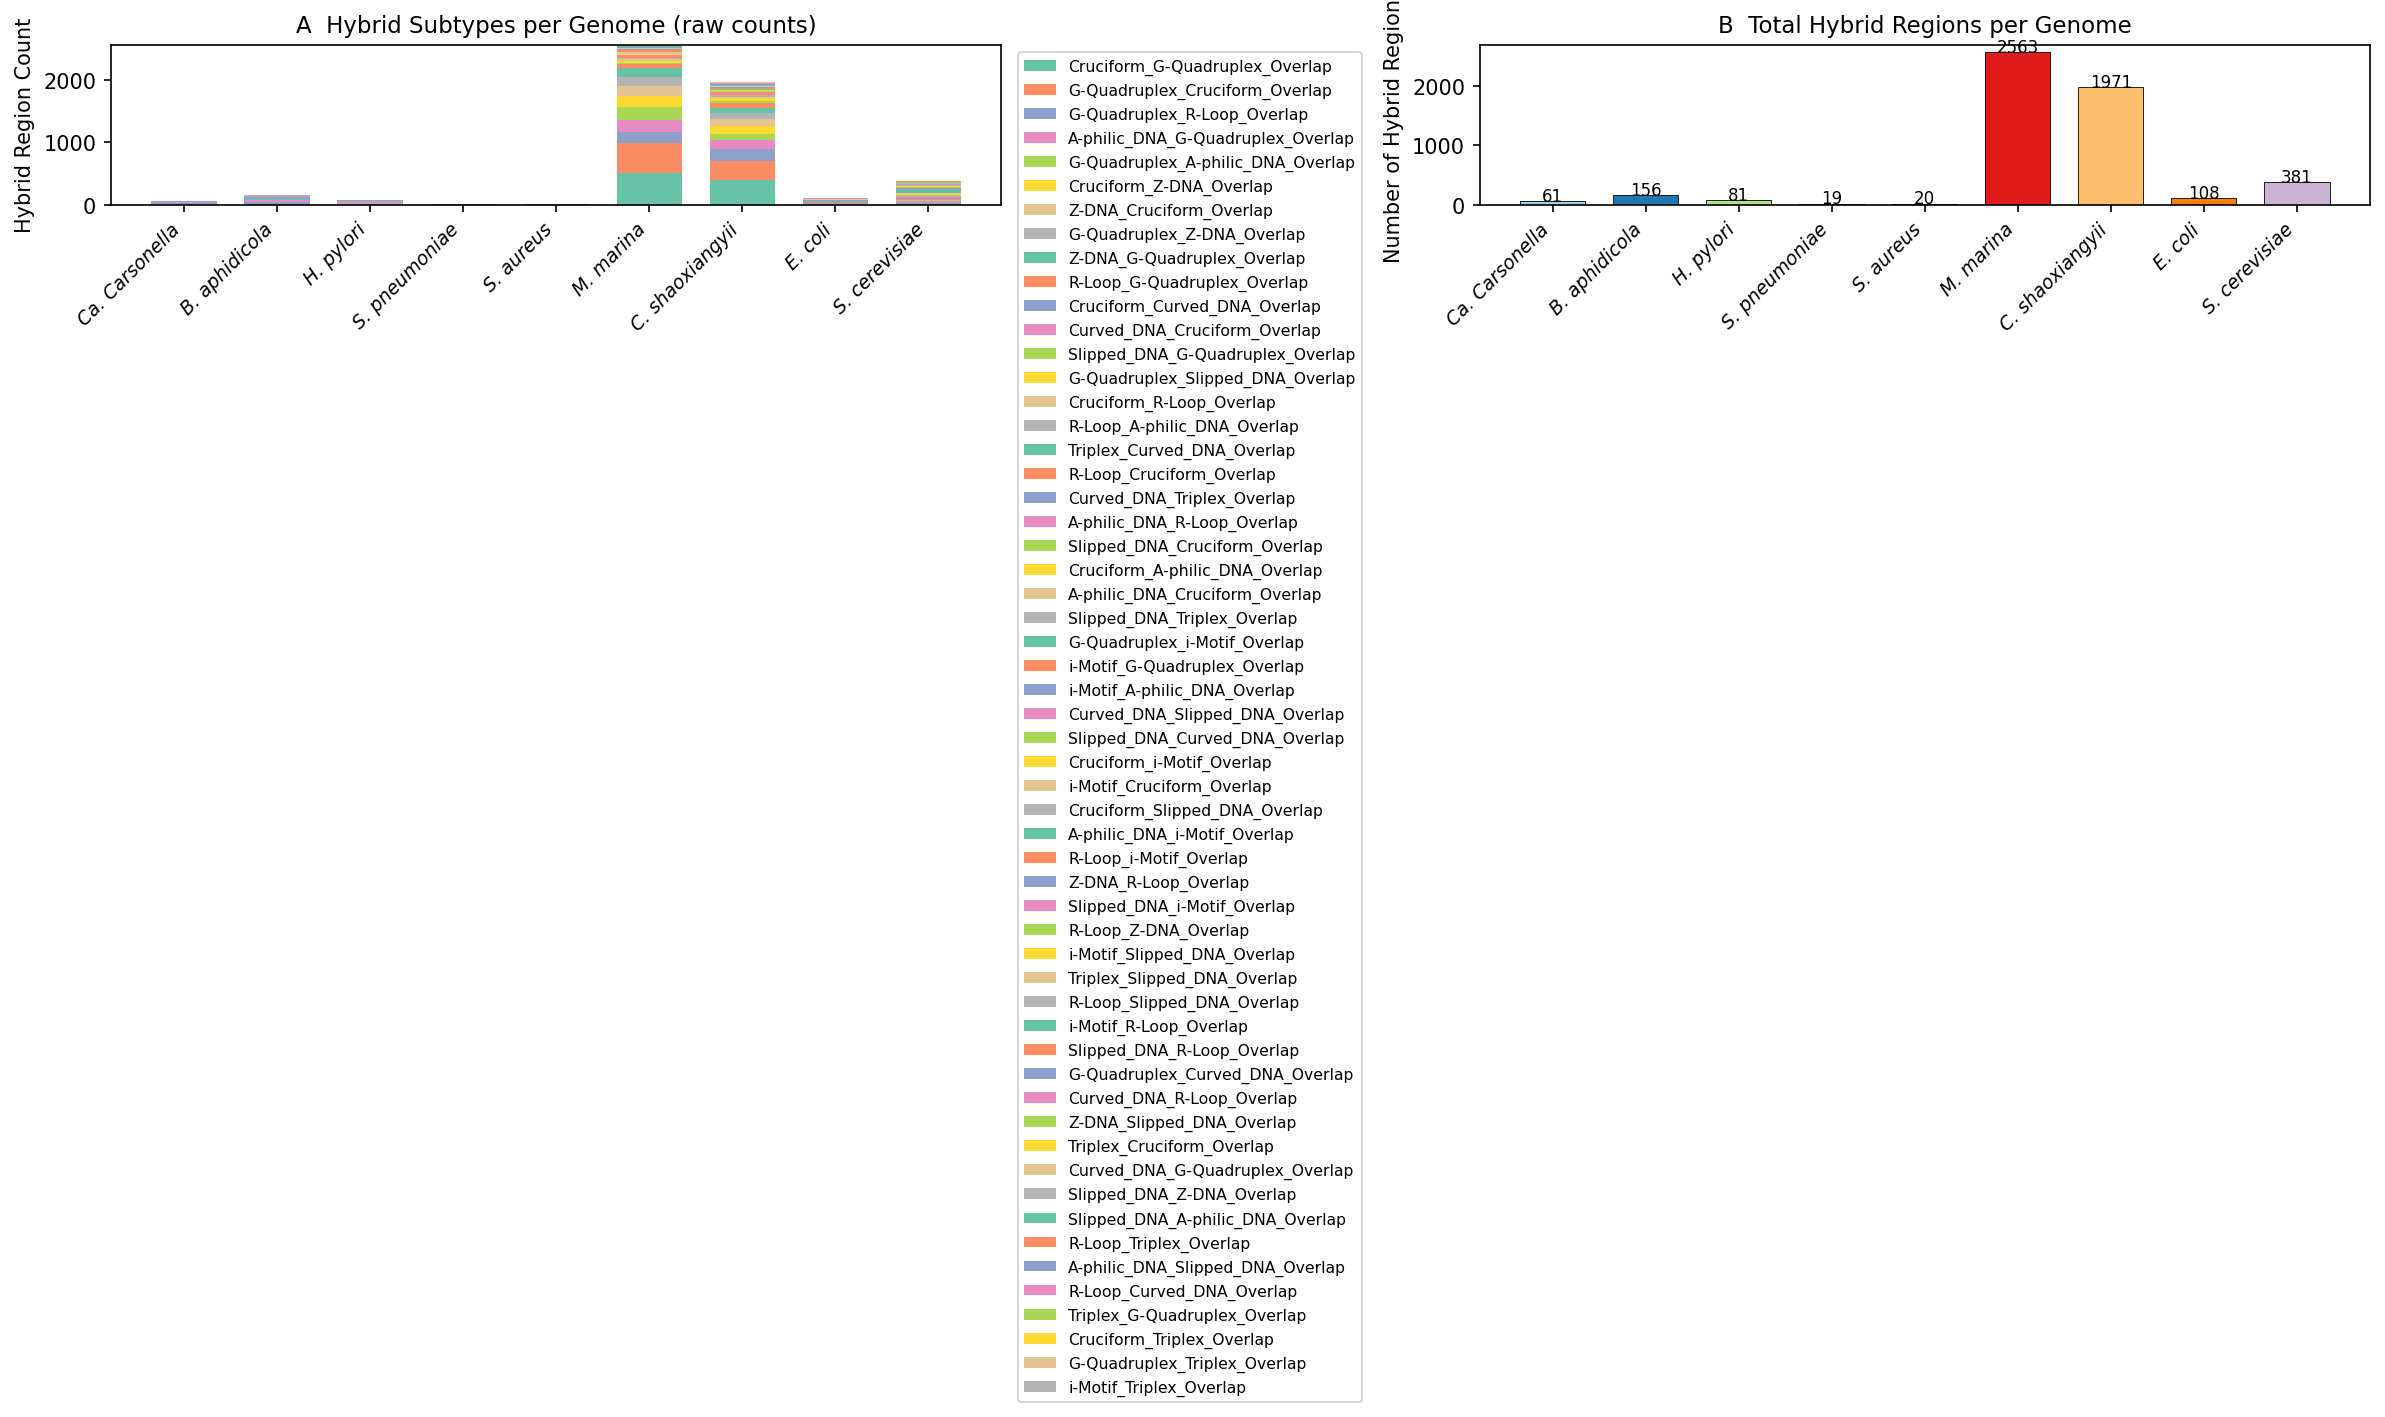

Figure 6 saved.


In [15]:
# Combine hybrid counts for normalised figure
hybrid_norm = HYBRID_TABLE.copy().astype(float)
for i, sn in enumerate(hybrid_norm.index):
    hybrid_norm.iloc[i] /= genome_sizes_mb[i]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 6A – raw hybrid counts by subtype (stacked bar)
if not HYBRID_TABLE.empty:
    pal_h = sns.color_palette("Set2", n_colors=len(HYBRID_TABLE.columns))
    bot   = np.zeros(len(HYBRID_TABLE))
    for j, col in enumerate(HYBRID_TABLE.columns):
        axes[0].bar(np.arange(len(HYBRID_TABLE)), HYBRID_TABLE[col].values,
                    0.7, bottom=bot, label=col, color=pal_h[j], edgecolor="none")
        bot += HYBRID_TABLE[col].values
    axes[0].set_xticks(np.arange(len(HYBRID_TABLE)))
    axes[0].set_xticklabels(HYBRID_TABLE.index, rotation=45, ha="right", fontstyle="italic", fontsize=9)
    axes[0].set_ylabel("Hybrid Region Count")
    axes[0].set_title("A  Hybrid Subtypes per Genome (raw counts)")
    axes[0].legend(ncol=1, fontsize=7.5, bbox_to_anchor=(1.01, 1), loc="upper left")

# 6B – hybrid coverage (%)
hybrid_cov = STATS["Hybrid Coverage"].values   # already as fraction from parse
hybrid_cov_pct = pd.to_numeric(
    STATS["Hybrid Coverage"].astype(str).str.replace("%", ""), errors="coerce").values
bars6b = axes[1].bar(np.arange(len(SHORT)), STATS["Hybrid Regions"].values,
                     0.7, color=sns.color_palette("Paired", n_colors=len(SHORT)),
                     edgecolor="k", linewidth=0.4)
axes[1].set_xticks(np.arange(len(SHORT)))
axes[1].set_xticklabels(SHORT, rotation=45, ha="right", fontstyle="italic", fontsize=9)
axes[1].set_ylabel("Number of Hybrid Regions")
axes[1].set_title("B  Total Hybrid Regions per Genome")
for bar in bars6b:
    h = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, h + 2, f"{int(h)}", ha="center", fontsize=8)

plt.tight_layout()
plt.savefig("Figure6_Hybrid_Analysis.pdf", bbox_inches="tight")
plt.savefig("Figure6_Hybrid_Analysis.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 6 saved.")


## Cell 9b · Figure 6b — Hybrid Region Deep Analysis

**Figure 6b** provides three additional panels:
(A) GC% vs. Hybrid density scatter (Pearson correlation);
(B) top-10 hybrid subtype proportions per genome (stacked 100% bar);
(C) hybrid count vs. cluster count scatter, highlighting the H–C co-occurrence.

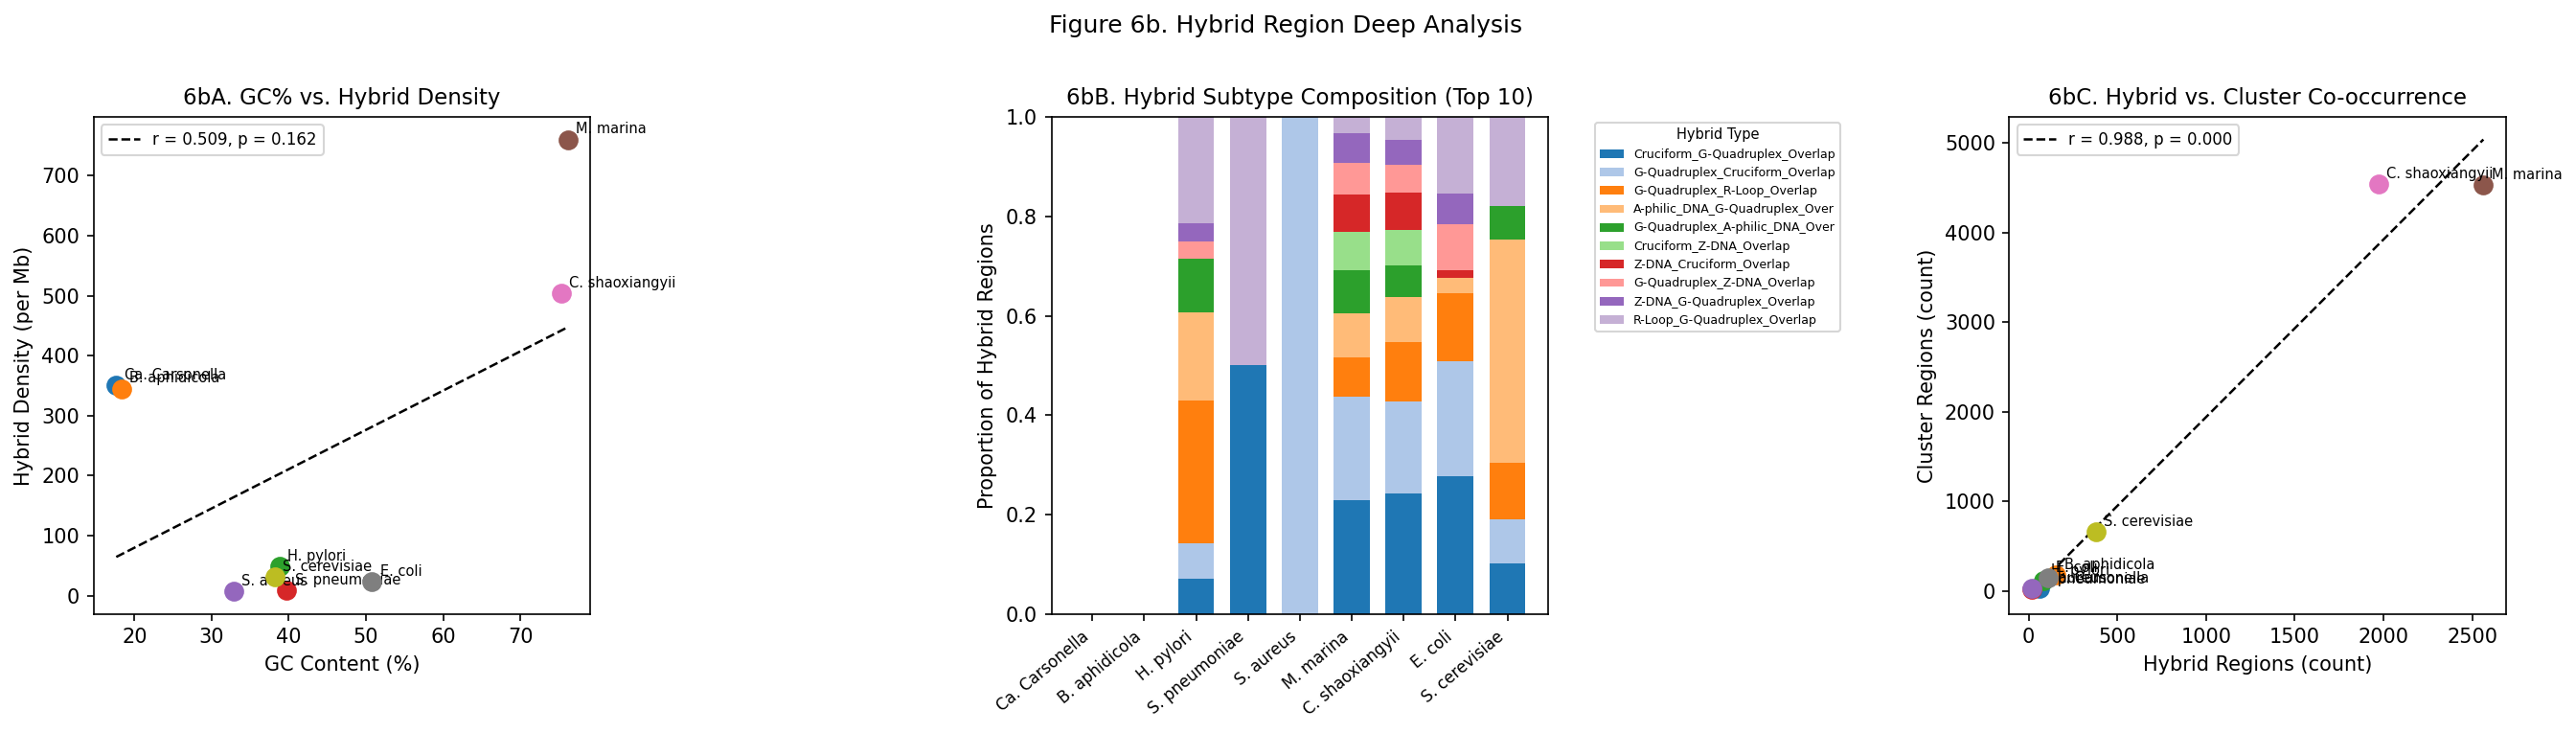

Figure 6b saved.


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 6bA — GC% vs. Hybrid density scatter
pal9 = sns.color_palette("tab10", 9)
for i, (sn, gc_val, hd) in enumerate(zip(SHORT, GC, hybrid_density)):
    axes[0].scatter(gc_val, hd, color=pal9[i], s=80, zorder=3)
    axes[0].annotate(sn, (gc_val, hd), textcoords="offset points",
                     xytext=(4, 3), fontsize=7)
x_fit = np.linspace(min(GC), max(GC), 100)
m, b, r, p, _ = stats.linregress(GC, hybrid_density)
axes[0].plot(x_fit, m * x_fit + b, "k--", lw=1.2,
             label=f"r = {r:.3f}, p = {p:.3f}")
axes[0].set_xlabel("GC Content (%)")
axes[0].set_ylabel("Hybrid Density (per Mb)")
axes[0].set_title("6bA. GC% vs. Hybrid Density")
axes[0].legend(fontsize=8)

# 6bB — hybrid subtype proportions (top 10 types, 100% stacked)
top10h = HYBRID_TABLE.sum(axis=0).nlargest(10).index
prop_h = HYBRID_TABLE[top10h].copy().astype(float)
row_sums = prop_h.sum(axis=1).replace(0, np.nan)
prop_h = prop_h.div(row_sums, axis=0).fillna(0)
pal_h2 = sns.color_palette("tab20", 10)
bot2 = np.zeros(len(prop_h))
for j, col in enumerate(top10h):
    axes[1].bar(range(len(prop_h)), prop_h[col].values, 0.7,
                bottom=bot2, color=pal_h2[j], label=col[:30], edgecolor="none")
    bot2 += prop_h[col].values
axes[1].set_xticks(range(len(SHORT)))
axes[1].set_xticklabels(SHORT, rotation=40, ha="right", fontsize=8)
axes[1].set_ylabel("Proportion of Hybrid Regions")
axes[1].set_title("6bB. Hybrid Subtype Composition (Top 10)")
axes[1].legend(loc="upper right", bbox_to_anchor=(1.6, 1), fontsize=6,
               title="Hybrid Type", title_fontsize=7)

# 6bC — hybrid count vs cluster count scatter
hcounts = STATS["Hybrid Regions"].values
ccounts = STATS["Cluster Regions"].values
for i, sn in enumerate(SHORT):
    axes[2].scatter(hcounts[i], ccounts[i], color=pal9[i], s=80, zorder=3)
    axes[2].annotate(sn, (hcounts[i], ccounts[i]),
                     textcoords="offset points", xytext=(4, 3), fontsize=7)
m2, b2, r2, p2, _ = stats.linregress(hcounts, ccounts)
xf2 = np.linspace(min(hcounts), max(hcounts), 100)
axes[2].plot(xf2, m2*xf2 + b2, "k--", lw=1.2, label=f"r = {r2:.3f}, p = {p2:.3f}")
axes[2].set_xlabel("Hybrid Regions (count)")
axes[2].set_ylabel("Cluster Regions (count)")
axes[2].set_title("6bC. Hybrid vs. Cluster Co-occurrence")
axes[2].legend(fontsize=8)

plt.suptitle("Figure 6b. Hybrid Region Deep Analysis", fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig("Figure6b_Hybrid_Deep_Analysis.pdf", bbox_inches="tight")
plt.savefig("Figure6b_Hybrid_Deep_Analysis.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 6b saved.")

## Cell 10 · Table 6 & Figure 7 — Non-B DNA Cluster Region Analysis

**Cluster regions** (Non_B_DNA_Clusters) are dense genomic windows harbouring
multiple distinct Non-B DNA motifs within a narrow sequence context, often
associated with replication stress hotspots and genomic instability.

In [17]:
# Cluster subtype breakdown
CLUSTER_TYPES = {}
for org in ORGANISMS:
    df_c = MOTIFS[org][MOTIFS[org]["Class"] == "Non-B_DNA_Clusters"]
    CLUSTER_TYPES[SHORT_NAMES.get(org, org)] = df_c["Subclass"].value_counts()

CLUSTER_TABLE = pd.DataFrame(CLUSTER_TYPES).T.fillna(0).astype(int)
CLUSTER_TABLE = CLUSTER_TABLE.loc[:, (CLUSTER_TABLE > 0).any(axis=0)]
col_order_c   = CLUSTER_TABLE.sum(axis=0).sort_values(ascending=False).index
CLUSTER_TABLE = CLUSTER_TABLE[col_order_c]

# Summary
tbl6_summary = STATS[["Short", "Cluster Regions", "Cluster Coverage"]].copy()
tbl6_summary.index = STATS["Short"]
tbl6_summary = tbl6_summary.drop(columns="Short")
tbl6_summary["Cluster Coverage"] = tbl6_summary["Cluster Coverage"].apply(lambda x: f"{x:.4f}%")
tbl6_summary["Cluster Regions"]  = tbl6_summary["Cluster Regions"].apply(lambda x: f"{int(x):,}")

print("Table 6A. Cluster Region Summary")
display(tbl6_summary)
print()
print("Table 6B. Cluster Subtype Composition")
display(CLUSTER_TABLE)


Table 6A. Cluster Region Summary


Cluster Regions Cluster Coverage
Short                                           
Ca. Carsonella               26          3.5790%
B. aphidicola               176          8.3311%
H. pylori                   109          1.4302%
S. pneumoniae                17          0.1953%
S. aureus                    22          0.1416%
M. marina                 4,530         72.0381%
C. shaoxiangyii           4,543         67.2842%
E. coli                     144          0.8002%
S. cerevisiae               656          0.9061%


Table 6B. Cluster Subtype Composition


Subclass         Mixed_Cluster_3_classes  Mixed_Cluster_4_classes  \
Ca. Carsonella                        23                        3   
B. aphidicola                        135                       40   
H. pylori                             82                       25   
S. pneumoniae                         17                        0   
S. aureus                             19                        3   
M. marina                           2917                     1286   
C. shaoxiangyii                     2991                     1258   
E. coli                              114                       29   
S. cerevisiae                        404                      201   

Subclass         Mixed_Cluster_5_classes  Mixed_Cluster_6_classes  \
Ca. Carsonella                         0                        0   
B. aphidicola                          1                        0   
H. pylori                              2                        0   
S. pneumoniae                          0                        0   
S. aureus                              0                        0   
M. marina                            300                       26   
C. shaoxiangyii                      262                       32   
E. coli                                1                        0   
S. cerevisiae                         46                        5   

Subclass         Mixed_Cluster_7_classes  
Ca. Carsonella                         0  
B. aphidicola                          0  
H. pylori                              0  
S. pneumoniae                          0  
S. aureus                              0  
M. marina                              1  
C. shaoxiangyii                        0  
E. coli                                0  
S. cerevisiae                          0

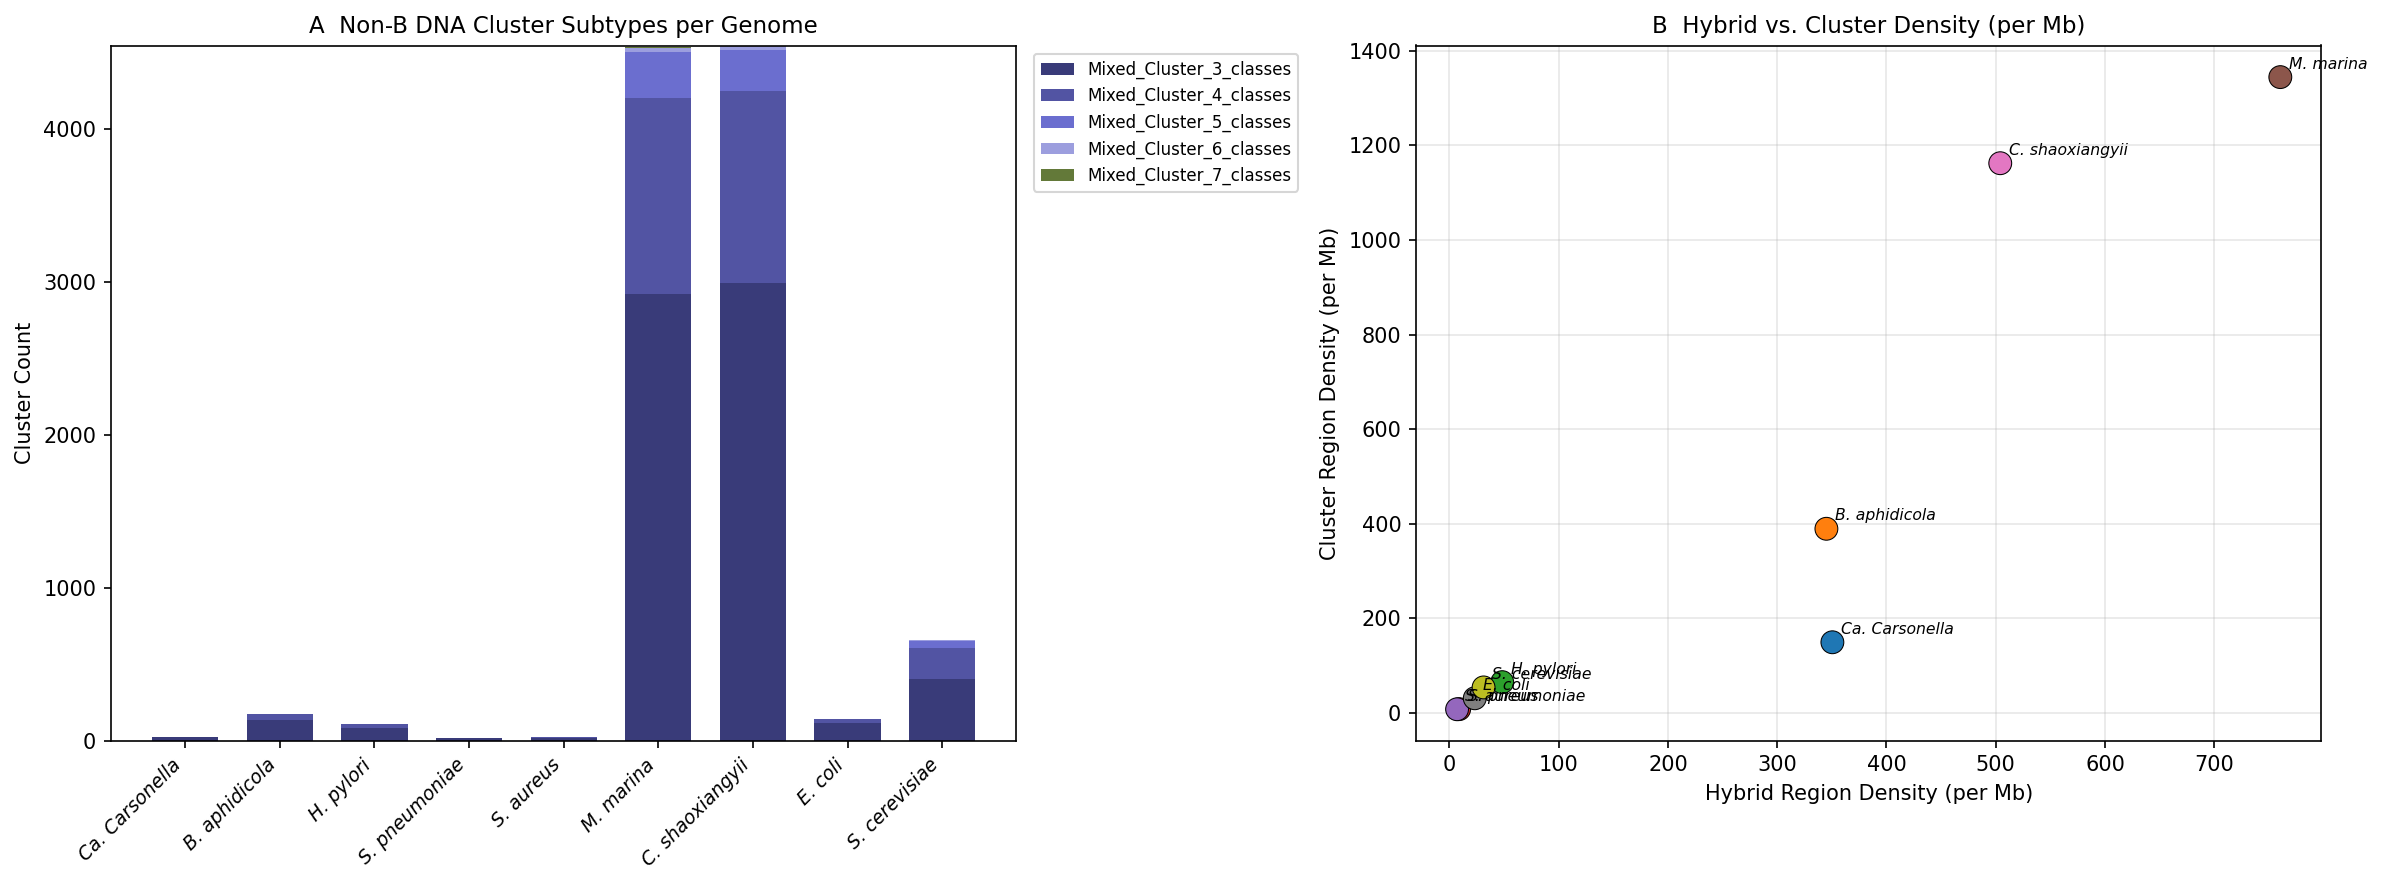

Figure 7 saved.


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 7A – cluster counts (stacked by subtype)
if not CLUSTER_TABLE.empty:
    pal_c = sns.color_palette("tab20b", n_colors=len(CLUSTER_TABLE.columns))
    bot   = np.zeros(len(CLUSTER_TABLE))
    for j, col in enumerate(CLUSTER_TABLE.columns):
        axes[0].bar(np.arange(len(CLUSTER_TABLE)), CLUSTER_TABLE[col].values,
                    0.7, bottom=bot, label=col, color=pal_c[j], edgecolor="none")
        bot += CLUSTER_TABLE[col].values
    axes[0].set_xticks(np.arange(len(CLUSTER_TABLE)))
    axes[0].set_xticklabels(CLUSTER_TABLE.index, rotation=45, ha="right", fontstyle="italic", fontsize=9)
    axes[0].set_ylabel("Cluster Count")
    axes[0].set_title("A  Non-B DNA Cluster Subtypes per Genome")
    axes[0].legend(ncol=1, fontsize=8, bbox_to_anchor=(1.01, 1), loc="upper left")

# 7B – Hybrid vs Cluster density (per Mb) scatter
hd = STATS["Hybrid Regions"].values  / genome_sizes_mb
cd = STATS["Cluster Regions"].values / genome_sizes_mb
sc = axes[1].scatter(hd, cd, c=sns.color_palette("tab10", n_colors=len(SHORT)),
                     s=120, edgecolors="k", linewidth=0.5, zorder=3)
for i, sn in enumerate(SHORT):
    axes[1].annotate(sn, (hd[i], cd[i]), fontsize=7.5, fontstyle="italic",
                     xytext=(4, 4), textcoords="offset points")
axes[1].set_xlabel("Hybrid Region Density (per Mb)")
axes[1].set_ylabel("Cluster Region Density (per Mb)")
axes[1].set_title("B  Hybrid vs. Cluster Density (per Mb)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("Figure7_Cluster_Analysis.pdf", bbox_inches="tight")
plt.savefig("Figure7_Cluster_Analysis.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 7 saved.")


## Cell 10b · Figure 7b — Cluster Region Deep Analysis

**Figure 7b** provides three panels examining cluster regions in depth:
(A) GC% vs. Cluster density scatter with correlation;
(B) cluster subtype complexity (proportion of 3/4/5/6/7-class clusters per genome);
(C) mean cluster length vs. GC% scatter, revealing composition-driven complexity.

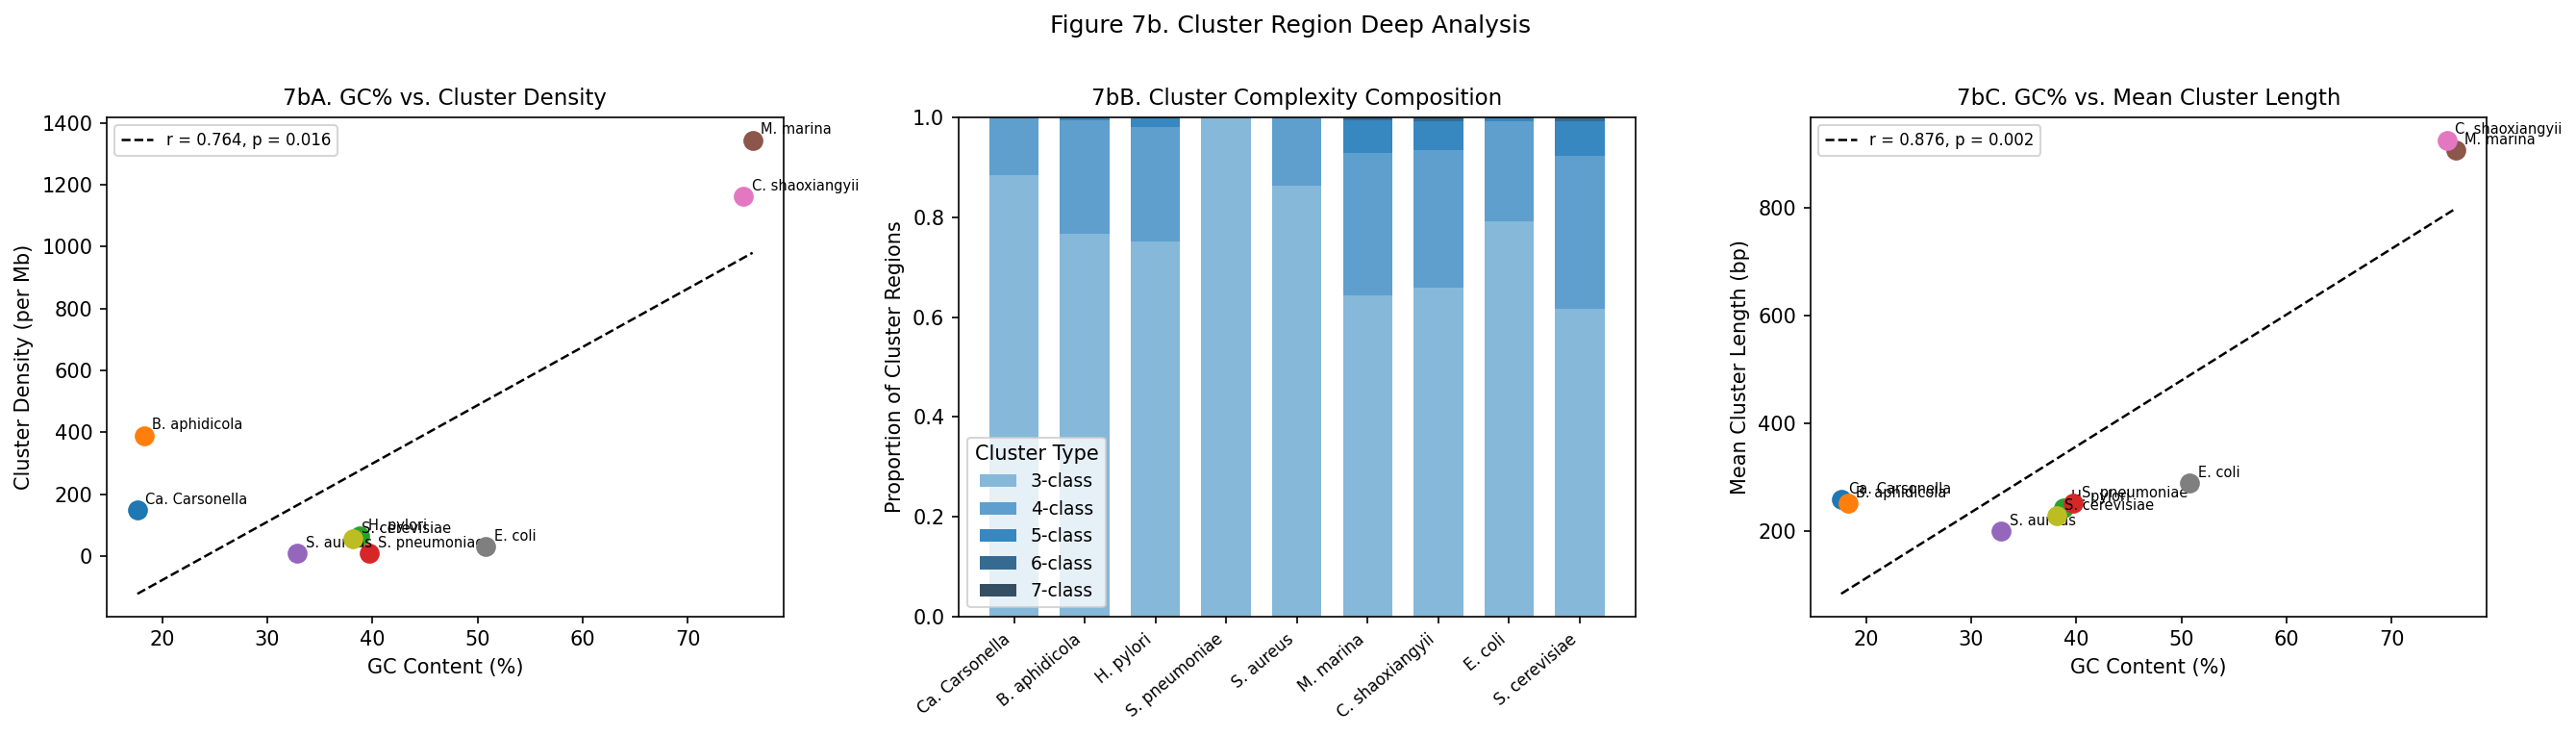

Figure 7b saved.


In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pal9 = sns.color_palette("tab10", 9)

cluster_density = STATS["Cluster Regions"].values / (STATS["Genome Length"].values / 1e6)

# 7bA — GC% vs. cluster density scatter
for i, sn in enumerate(SHORT):
    axes[0].scatter(GC[i], cluster_density[i], color=pal9[i], s=80, zorder=3)
    axes[0].annotate(sn, (GC[i], cluster_density[i]),
                     textcoords="offset points", xytext=(4, 3), fontsize=7)
m3, b3, r3, p3, _ = stats.linregress(GC, cluster_density)
xf3 = np.linspace(min(GC), max(GC), 100)
axes[0].plot(xf3, m3*xf3+b3, "k--", lw=1.2, label=f"r = {r3:.3f}, p = {p3:.3f}")
axes[0].set_xlabel("GC Content (%)")
axes[0].set_ylabel("Cluster Density (per Mb)")
axes[0].set_title("7bA. GC% vs. Cluster Density")
axes[0].legend(fontsize=8)

# 7bB — cluster complexity composition (proportion of 3/4/5/6/7-class clusters)
cluster_subtypes = ["Mixed_Cluster_3_classes", "Mixed_Cluster_4_classes",
                    "Mixed_Cluster_5_classes", "Mixed_Cluster_6_classes",
                    "Mixed_Cluster_7_classes"]
avail_ct = [c for c in cluster_subtypes if c in CLUSTER_TABLE.columns]
prop_c = CLUSTER_TABLE[avail_ct].copy().astype(float)
row_sums_c = prop_c.sum(axis=1).replace(0, np.nan)
prop_c = prop_c.div(row_sums_c, axis=0).fillna(0)
pal_comp = sns.color_palette("Blues_d", len(avail_ct))
labels_ct = [c.replace("Mixed_Cluster_", "").replace("_classes", "-class") for c in avail_ct]
bot3 = np.zeros(len(prop_c))
for j, (col, lbl) in enumerate(zip(avail_ct, labels_ct)):
    axes[1].bar(range(len(prop_c)), prop_c[col].values, 0.7,
                bottom=bot3, color=pal_comp[j], label=lbl, edgecolor="none")
    bot3 += prop_c[col].values
axes[1].set_xticks(range(len(SHORT)))
axes[1].set_xticklabels(SHORT, rotation=40, ha="right", fontsize=8)
axes[1].set_ylabel("Proportion of Cluster Regions")
axes[1].set_title("7bB. Cluster Complexity Composition")
axes[1].legend(fontsize=9, title="Cluster Type")

# 7bC — mean cluster length vs. GC%
mean_cluster_len = []
for org in ORGANISMS:
    df_c = MOTIFS[org][MOTIFS[org]["Class"] == "Non-B_DNA_Clusters"]
    if len(df_c) > 0 and "Length" in df_c.columns:
        mean_cluster_len.append(df_c["Length"].mean())
    else:
        mean_cluster_len.append(np.nan)
mean_cluster_len = np.array(mean_cluster_len)

for i, sn in enumerate(SHORT):
    if not np.isnan(mean_cluster_len[i]):
        axes[2].scatter(GC[i], mean_cluster_len[i], color=pal9[i], s=80, zorder=3)
        axes[2].annotate(sn, (GC[i], mean_cluster_len[i]),
                         textcoords="offset points", xytext=(4, 3), fontsize=7)
valid = ~np.isnan(mean_cluster_len)
if valid.sum() >= 3:
    m4, b4, r4, p4, _ = stats.linregress(GC[valid], mean_cluster_len[valid])
    xf4 = np.linspace(min(GC), max(GC), 100)
    axes[2].plot(xf4, m4*xf4+b4, "k--", lw=1.2, label=f"r = {r4:.3f}, p = {p4:.3f}")
    axes[2].legend(fontsize=8)
axes[2].set_xlabel("GC Content (%)")
axes[2].set_ylabel("Mean Cluster Length (bp)")
axes[2].set_title("7bC. GC% vs. Mean Cluster Length")

plt.suptitle("Figure 7b. Cluster Region Deep Analysis", fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig("Figure7b_Cluster_Deep_Analysis.pdf", bbox_inches="tight")
plt.savefig("Figure7b_Cluster_Deep_Analysis.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 7b saved.")

## Cell 11 · Table 7 & Figure 8 — Structural Complexity and Occupancy Metrics

**Table 7** compares the suite of structural metrics computed by NonBDNAFinder.
**Figure 8** provides a radar (spider) chart for multi-variate visual comparison.

In [20]:
metric_cols = [
    "SLI", "Structural Intensity", "Weighted Structural Coverage",
    "SCI (Structural Complexity Index)", "Mean Overlap Depth",
    "CV (Clustering Coefficient)", "Max Local Density (W=1,000 bp)",
    "Mean Inter-Motif Distance",
]
tbl7 = STATS[metric_cols].copy()
tbl7.index = STATS["Short"]
tbl7.columns = ["SLI", "SI", "WSC", "SCI", "Mean Overlap Depth",
                "CV (CC)", "Max Local Density", "Mean IMD (bp)"]

print("Table 7. Structural Complexity and Occupancy Metrics")
print("=" * 100)
display(tbl7.round(4))


Table 7. Structural Complexity and Occupancy Metrics


SLI      SI     WSC     SCI  Mean Overlap Depth  CV (CC)  \
Short                                                                          
Ca. Carsonella   0.1121  0.1288  0.0780  0.1546              1.1290   1.4556   
B. aphidicola    0.1107  0.1296  0.0453  0.1572              1.1515   1.5416   
H. pylori        0.0522  0.0684  0.0238  0.1971              1.0844   1.1964   
S. pneumoniae    0.0278  0.0305  0.0134  0.0870              1.0297   1.1702   
S. aureus        0.0173  0.0195  0.0119  0.0541              1.0158   1.1606   
M. marina        0.9147  2.1412  0.7173  1.7998              1.2382  40.1915   
C. shaoxiangyii  0.8677  2.0510  0.6860  1.8225              1.2059  25.1040   
E. coli          0.0615  0.0864  0.0291  0.1460              1.0458   1.2254   
S. cerevisiae    0.0305  0.0349  0.0131  0.0834              1.2714   3.4807   

                 Max Local Density  Mean IMD (bp)  
Short                                              
Ca. Carsonella               0.027         110.97  
B. aphidicola                0.027         115.77  
H. pylori                    0.011         443.78  
S. pneumoniae                0.020         798.37  
S. aureus                    0.015        1323.46  
M. marina                    0.039           7.84  
C. shaoxiangyii              0.029          13.36  
E. coli                      0.012         424.73  
S. cerevisiae                0.076          61.45

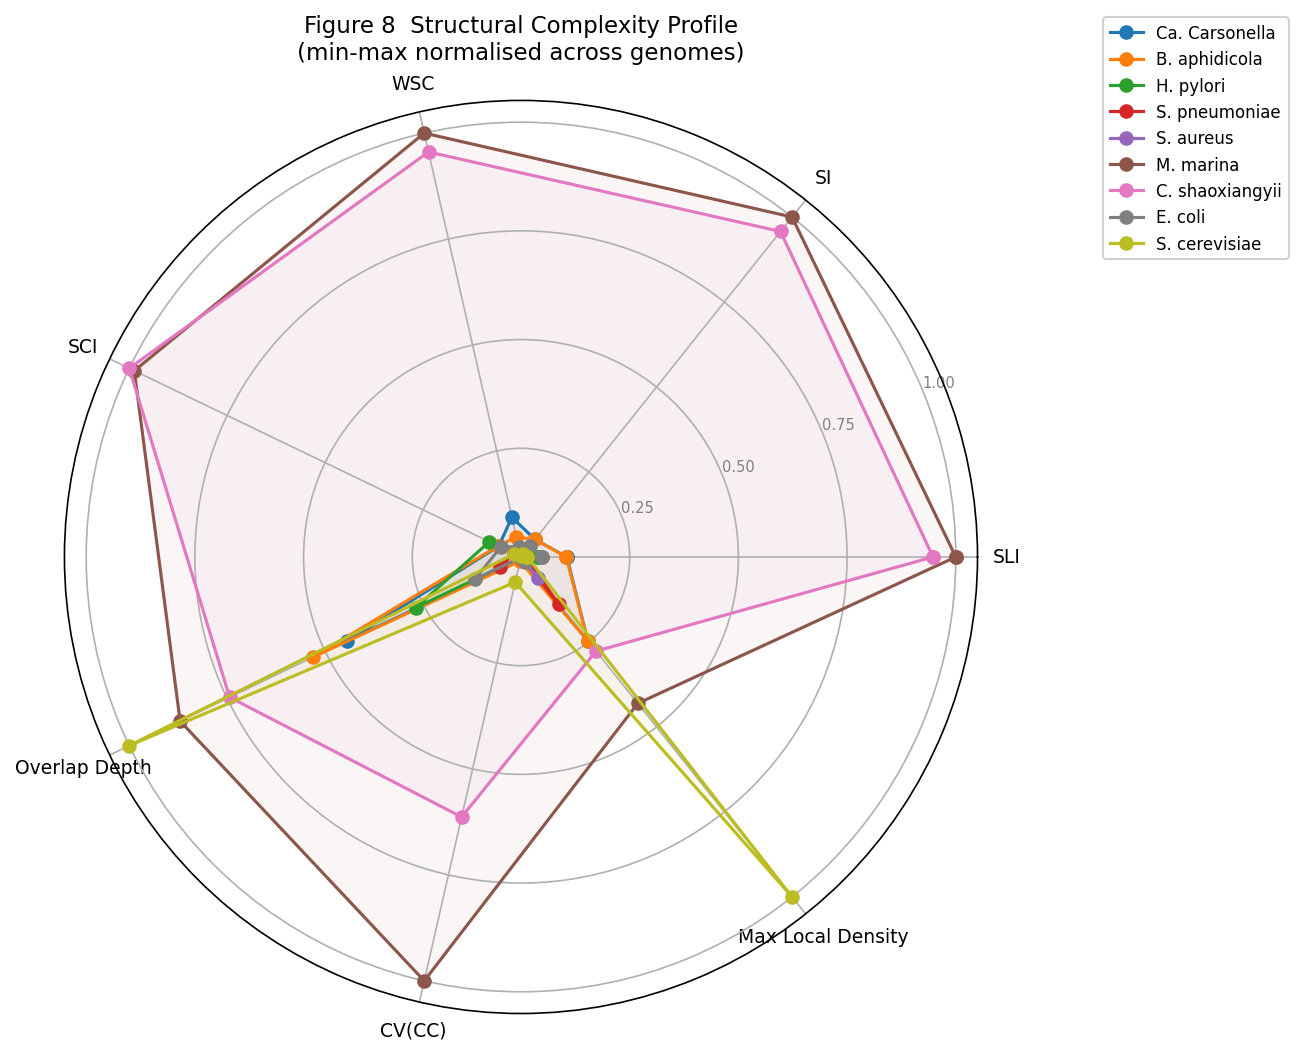

Figure 8 saved.


In [21]:
# Radar chart
radar_metrics = ["SLI", "Structural Intensity", "Weighted Structural Coverage",
                 "SCI (Structural Complexity Index)", "Mean Overlap Depth",
                 "CV (Clustering Coefficient)", "Max Local Density (W=1,000 bp)"]
radar_labels  = ["SLI", "SI", "WSC", "SCI", "Overlap Depth", "CV(CC)", "Max Local Density"]

N       = len(radar_metrics)
angles  = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

pal_r = sns.color_palette("tab10", n_colors=len(SHORT))

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

# Normalise each metric 0-1
normed = STATS[radar_metrics].copy()
for c in radar_metrics:
    mn, mx = normed[c].min(), normed[c].max()
    if mx > mn:
        normed[c] = (normed[c] - mn) / (mx - mn)
    else:
        normed[c] = 0.0

for i, (org, sn) in enumerate(zip(ORGANISMS, SHORT)):
    vals = normed.loc[org, radar_metrics].tolist()
    vals += vals[:1]
    ax.plot(angles, vals, "-o", linewidth=1.5, color=pal_r[i], label=sn)
    ax.fill(angles, vals, alpha=0.05, color=pal_r[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_labels, size=9)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0.25", "0.50", "0.75", "1.00"], size=7, color="grey")
ax.set_title("Figure 8  Structural Complexity Profile\n(min-max normalised across genomes)", pad=20, fontsize=11)
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1), fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.savefig("Figure8_Structural_Metrics_Radar.pdf", bbox_inches="tight")
plt.savefig("Figure8_Structural_Metrics_Radar.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 8 saved.")


## Cell 12 · Table 8 & Figure 9 — Structural Diversity Indices

**Table 8** and **Figure 9** compare diversity metrics — the Simpson Diversity
Index (D), Effective Class Number (N_eff), and Structural Dominance Ratio — that
quantify how evenly distributed Non-B DNA classes are across each genome.

In [22]:
div_cols = ["Simpson Diversity Index (D)", "Effective Class Number (Neff)",
            "Structural Dominance Ratio", "Max Class Diversity", "Max Cluster Score"]
tbl8 = STATS[div_cols].copy()
tbl8.index = STATS["Short"]
tbl8.columns = ["Simpson D", "Neff", "Dominance Ratio", "Max Class Diversity", "Max Cluster Score"]
print("Table 8. Structural Diversity Indices")
print("=" * 80)
display(tbl8.round(4))


Table 8. Structural Diversity Indices


Simpson D    Neff  Dominance Ratio  Max Class Diversity  \
Short                                                                      
Ca. Carsonella      0.3576  1.5567           0.7779                  5.0   
B. aphidicola       0.3887  1.6358           0.7625                  5.0   
H. pylori           0.7558  4.0952           0.3077                  6.0   
S. pneumoniae       0.6895  3.2203           0.3944                  4.0   
S. aureus           0.6851  3.1752           0.4194                  5.0   
M. marina           0.5895  2.4363           0.5975                  8.0   
C. shaoxiangyii     0.6052  2.5329           0.5781                  7.0   
E. coli             0.5971  2.4821           0.5959                  5.0   
S. cerevisiae       0.7126  3.4792           0.4392                  9.0   

                 Max Cluster Score  
Short                               
Ca. Carsonella               0.085  
B. aphidicola                0.108  
H. pylori                    0.066  
S. pneumoniae                0.057  
S. aureus                    0.060  
M. marina                    0.231  
C. shaoxiangyii              0.175  
E. coli                      0.055  
S. cerevisiae                0.532

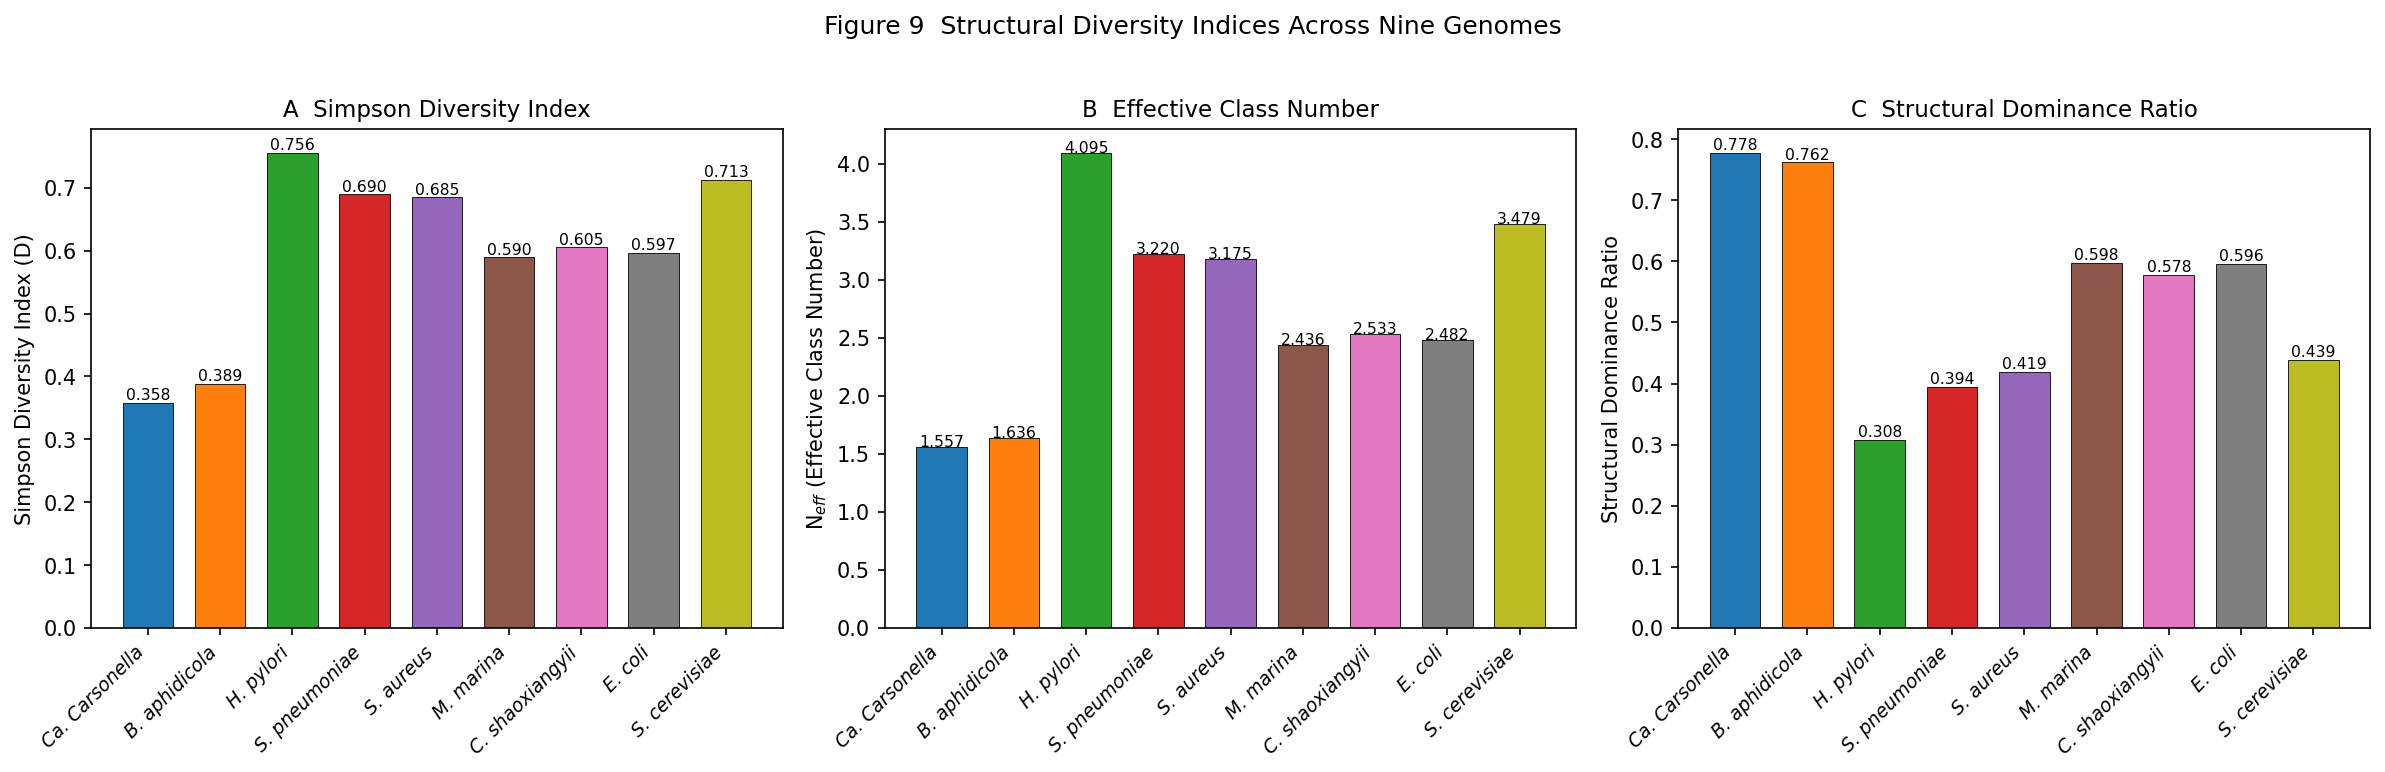

Figure 9 saved.


In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
pal9 = sns.color_palette("tab10", n_colors=len(SHORT))

for ax_i, (metric, label, title) in enumerate([
    ("Simpson Diversity Index (D)", "Simpson Diversity Index (D)",
     "A  Simpson Diversity Index"),
    ("Effective Class Number (Neff)", "N$_{eff}$ (Effective Class Number)",
     "B  Effective Class Number"),
    ("Structural Dominance Ratio", "Structural Dominance Ratio",
     "C  Structural Dominance Ratio"),
]):
    vals = STATS[metric].values
    bars = axes[ax_i].bar(np.arange(len(SHORT)), vals, 0.7,
                          color=pal9, edgecolor="k", linewidth=0.4)
    axes[ax_i].set_xticks(np.arange(len(SHORT)))
    axes[ax_i].set_xticklabels(SHORT, rotation=45, ha="right", fontstyle="italic", fontsize=9)
    axes[ax_i].set_ylabel(label)
    axes[ax_i].set_title(title)
    for bar in bars:
        h = bar.get_height()
        axes[ax_i].text(bar.get_x() + bar.get_width()/2, h + 0.005,
                        f"{h:.3f}", ha="center", fontsize=7.5)

plt.suptitle("Figure 9  Structural Diversity Indices Across Nine Genomes", y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig("Figure9_Diversity_Indices.pdf", bbox_inches="tight")
plt.savefig("Figure9_Diversity_Indices.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 9 saved.")


## Cell 13 · Figure 10 — Genome Size vs. Key Non-B DNA Metrics

**Figure 10** explores whether genome size predicts Non-B DNA burden, testing
the hypothesis that larger genomes accumulate proportionally more structural motifs.

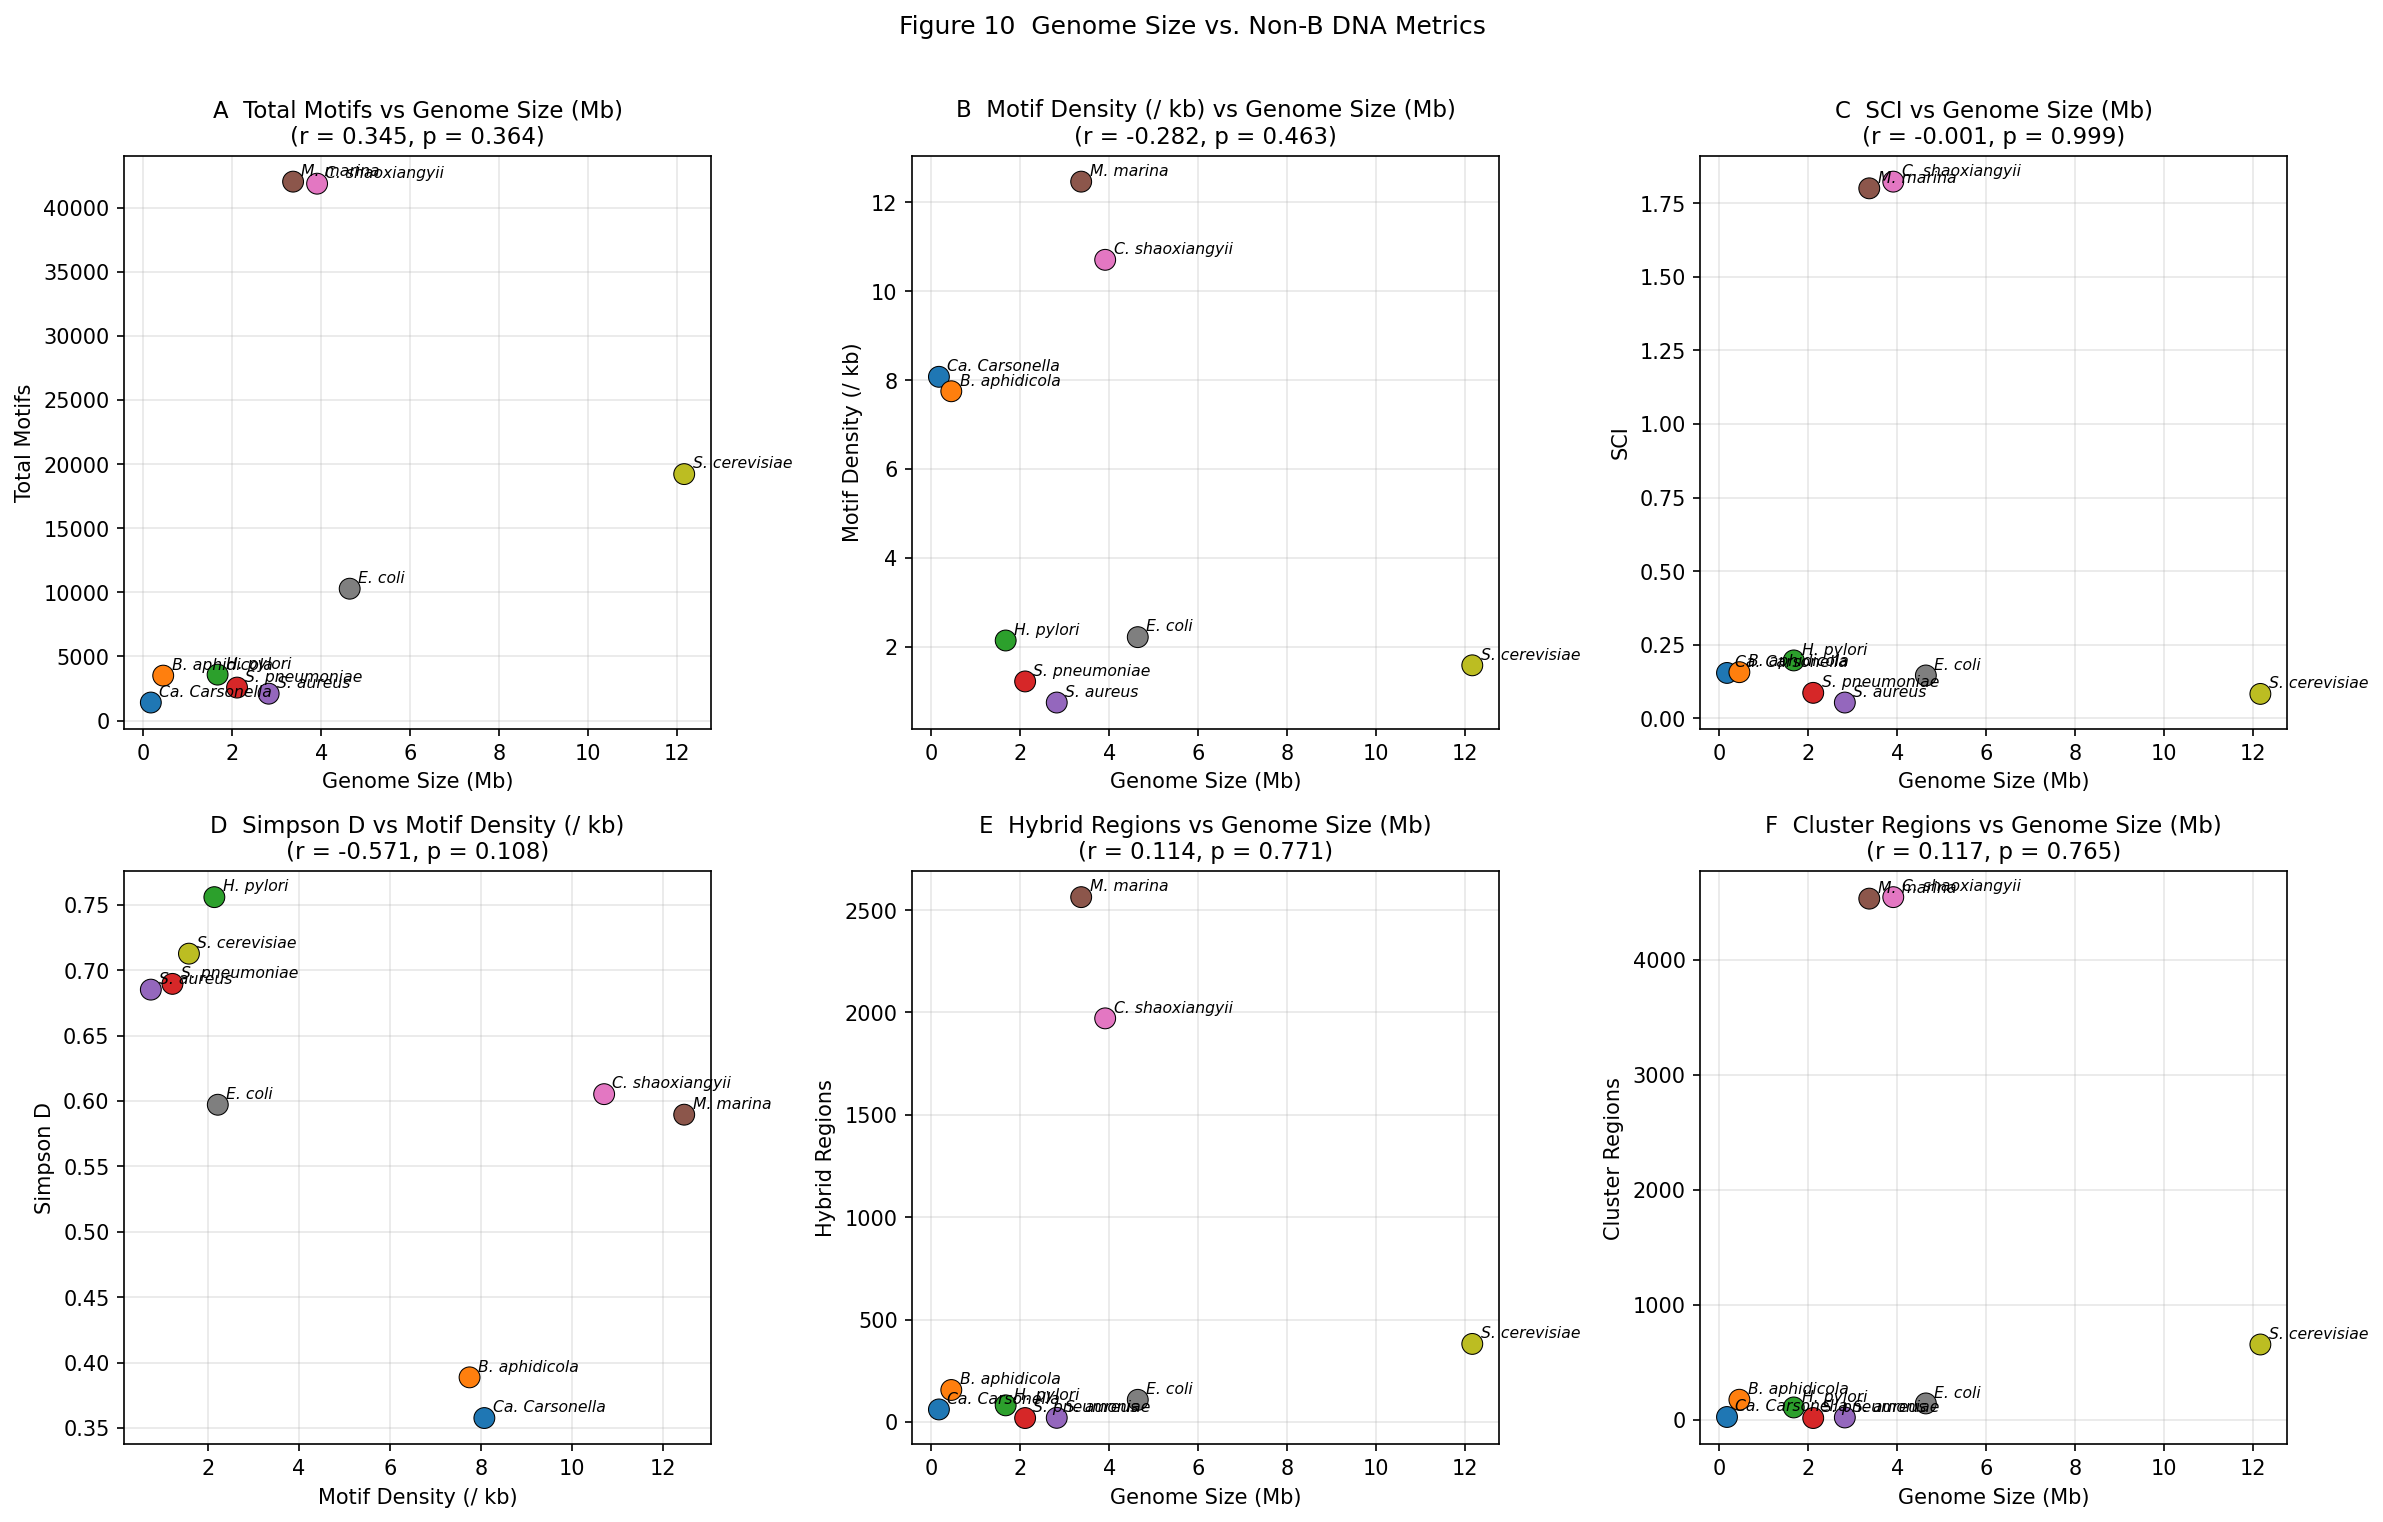

Figure 10 saved.


In [24]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
pal10 = sns.color_palette("tab10", n_colors=len(SHORT))

scatter_pairs = [
    ("Genome Length", "Motifs (excl. Hybrid/Cluster)",
     "Genome Size (Mb)", "Total Motifs", "A"),
    ("Genome Length", "Motif Density",
     "Genome Size (Mb)", "Motif Density (/ kb)", "B"),
    ("Genome Length", "SCI (Structural Complexity Index)",
     "Genome Size (Mb)", "SCI", "C"),
    ("Motif Density", "Simpson Diversity Index (D)",
     "Motif Density (/ kb)", "Simpson D", "D"),
    ("Genome Length", "Hybrid Regions",
     "Genome Size (Mb)", "Hybrid Regions", "E"),
    ("Genome Length", "Cluster Regions",
     "Genome Size (Mb)", "Cluster Regions", "F"),
]

for ax, (xcol, ycol, xlabel, ylabel, panel) in zip(axes.flat, scatter_pairs):
    xv = STATS[xcol].values.copy()
    yv = STATS[ycol].values.copy()
    if xcol == "Genome Length":
        xv = xv / 1e6
    ax.scatter(xv, yv, c=pal10, s=100, edgecolors="k", linewidth=0.5, zorder=3)
    for i, sn in enumerate(SHORT):
        ax.annotate(sn, (xv[i], yv[i]), fontsize=7.5, fontstyle="italic",
                    xytext=(4, 3), textcoords="offset points")
    # Pearson correlation
    r, p = stats.pearsonr(xv, yv)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{panel}  {ylabel} vs {xlabel}\n(r = {r:.3f}, p = {p:.3f})")
    ax.grid(alpha=0.3)

plt.suptitle("Figure 10  Genome Size vs. Non-B DNA Metrics", y=1.01, fontsize=12)
plt.tight_layout()
plt.savefig("Figure10_Genome_Size_Correlations.pdf", bbox_inches="tight")
plt.savefig("Figure10_Genome_Size_Correlations.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 10 saved.")


## Cell 13b · Figure 10b — GC Content vs. Key Non-B DNA Structural Metrics

**Figure 10b** shows how GC content (the dominant sequence-compositional determinant) correlates with class-specific densities. Six scatter plots test the GC hypothesis: GC-rich genomes are predicted to have higher G-Quadruplex, Z-DNA, and R-Loop densities, whereas AT-rich genomes are predicted to have higher Curved_DNA and A-philic_DNA densities.

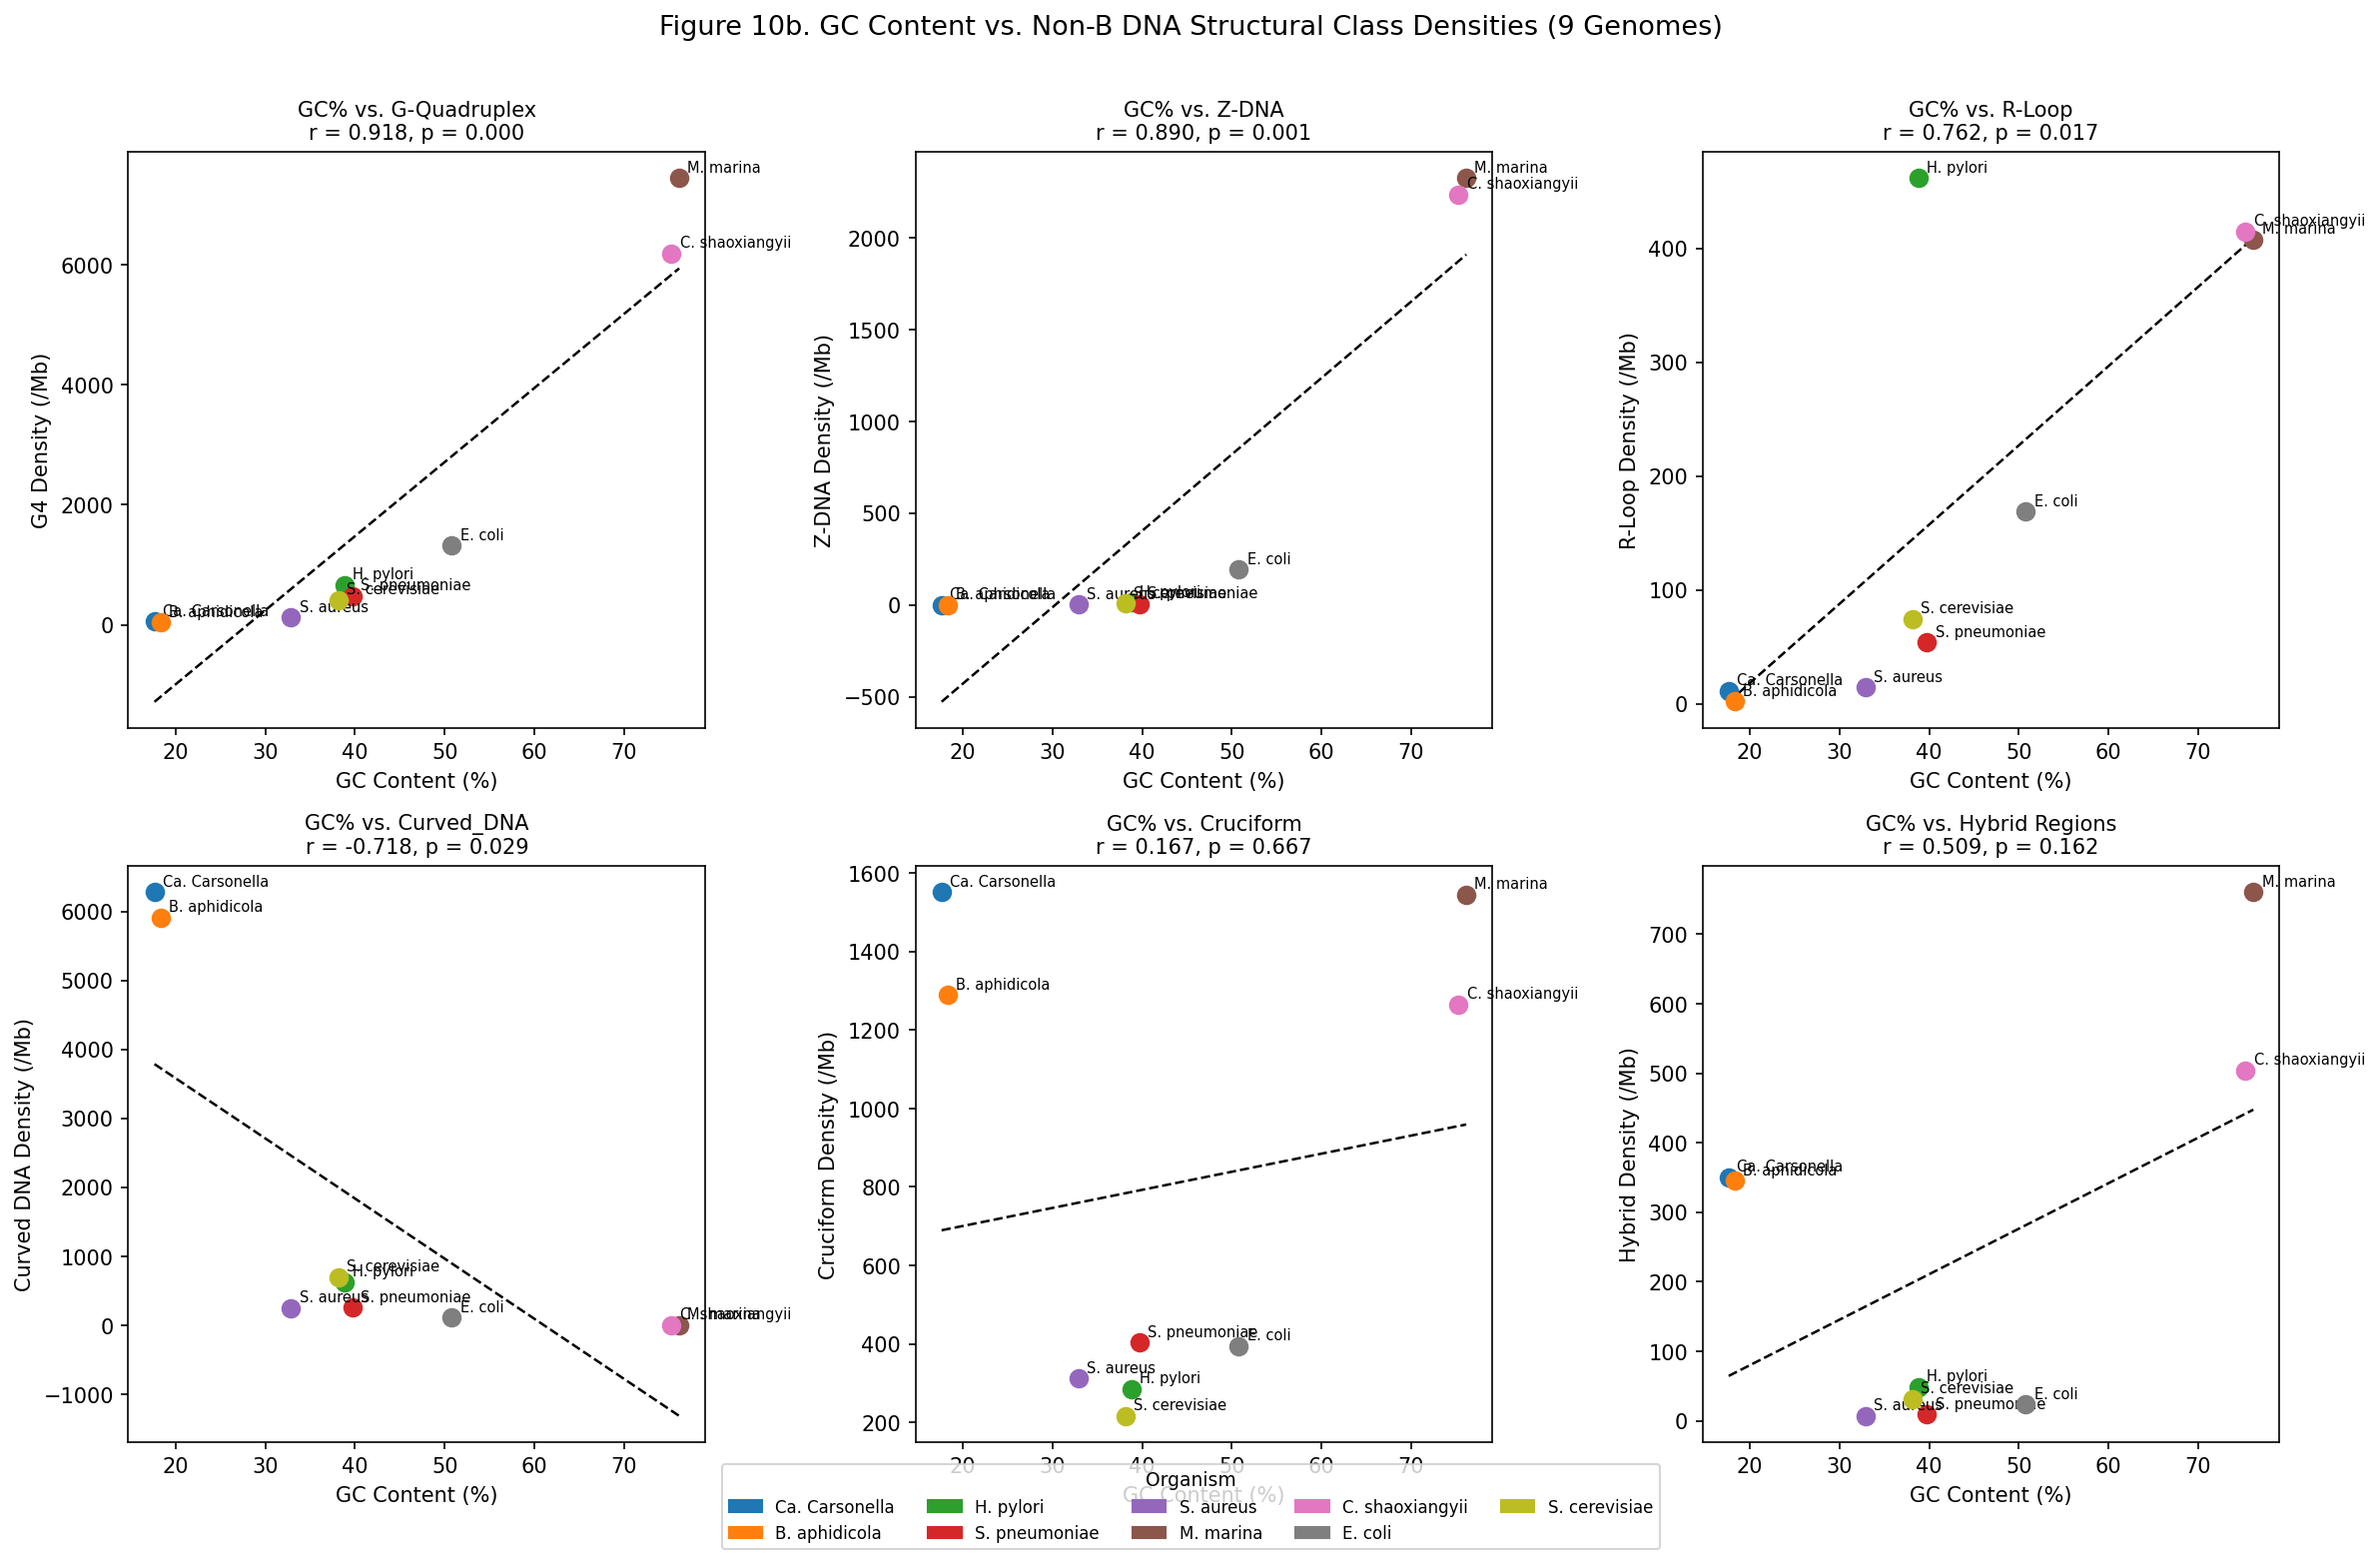

Figure 10b saved.


In [25]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
pal10b = sns.color_palette("tab10", 9)

# Metrics to plot vs GC
gc_metrics = [
    ("G-Quadruplex", "G4 Density (/Mb)"),
    ("Z-DNA", "Z-DNA Density (/Mb)"),
    ("R-Loop", "R-Loop Density (/Mb)"),
    ("Curved_DNA", "Curved DNA Density (/Mb)"),
    ("Cruciform", "Cruciform Density (/Mb)"),
    ("Hybrid Regions", "Hybrid Density (/Mb)"),
]

for ax, (cls, ylabel) in zip(axes.flat, gc_metrics):
    if cls in ["Hybrid Regions"]:
        yvals = STATS["Hybrid Regions"].values / (STATS["Genome Length"].values / 1e6)
    else:
        yvals = CLASS_TABLE_NORM[cls].values if cls in CLASS_TABLE_NORM.columns else np.zeros(len(ORGANISMS))
    
    for i, sn in enumerate(SHORT):
        ax.scatter(GC[i], yvals[i], color=pal10b[i], s=70, zorder=3, label=sn)
        ax.annotate(sn, (GC[i], yvals[i]), textcoords="offset points",
                    xytext=(4, 3), fontsize=7)
    
    valid = ~np.isnan(yvals)
    if valid.sum() >= 3:
        m, b, r, p, _ = stats.linregress(GC[valid], yvals[valid])
        xf = np.linspace(min(GC), max(GC), 100)
        ax.plot(xf, m * xf + b, "k--", lw=1.2)
        ax.set_title(f"GC% vs. {cls}\nr = {r:.3f}, p = {p:.3f}", fontsize=10)
    else:
        ax.set_title(f"GC% vs. {cls}", fontsize=10)
    
    ax.set_xlabel("GC Content (%)")
    ax.set_ylabel(ylabel)

handles = [mpatches.Patch(color=pal10b[i], label=s) for i, s in enumerate(SHORT)]
fig.legend(handles=handles, loc="lower center", ncol=5, fontsize=8,
           title="Organism", title_fontsize=9, bbox_to_anchor=(0.5, -0.02))
fig.suptitle("Figure 10b. GC Content vs. Non-B DNA Structural Class Densities (9 Genomes)",
             fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig("Figure10b_GC_Correlations.pdf", bbox_inches="tight")
plt.savefig("Figure10b_GC_Correlations.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 10b saved.")

## Cell 14 · Figure 11 — Coverage and Structural Occupancy

**Figure 11** contrasts the fraction of each genome physically covered by
Non-B DNA motifs (**coverage**) with the *Structural Landscape Index* (**SLI**),
which weights coverage by the depth of structural overlap.

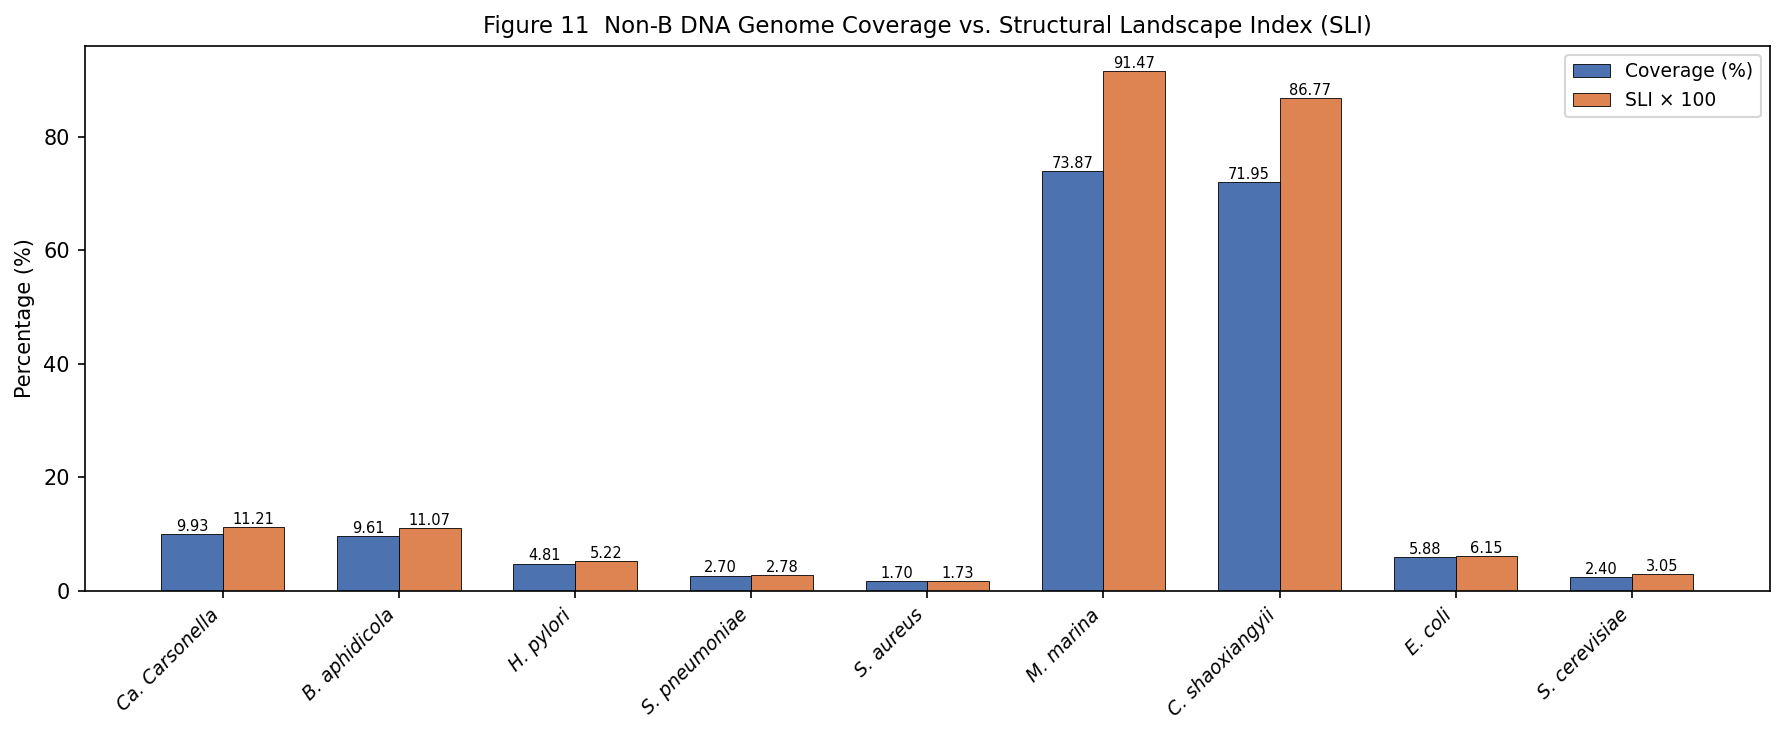

Figure 11 saved.


In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
x    = np.arange(len(SHORT))
w    = 0.35
pal_cov = ["#4C72B0"] * len(SHORT)

cov_pct = STATS["Coverage Fraction"].values * 100
sli     = STATS["SLI"].values * 100

bars_cov = ax.bar(x - w/2, cov_pct, w, label="Coverage (%)", color="#4C72B0", edgecolor="k", lw=0.4)
bars_sli = ax.bar(x + w/2, sli,     w, label="SLI × 100",    color="#DD8452", edgecolor="k", lw=0.4)

ax.set_xticks(x)
ax.set_xticklabels(SHORT, rotation=45, ha="right", fontstyle="italic", fontsize=9)
ax.set_ylabel("Percentage (%)")
ax.set_title("Figure 11  Non-B DNA Genome Coverage vs. Structural Landscape Index (SLI)")
ax.legend(fontsize=9)
for bar in list(bars_cov) + list(bars_sli):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.2f}",
            ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.savefig("Figure11_Coverage_SLI.pdf", bbox_inches="tight")
plt.savefig("Figure11_Coverage_SLI.png", dpi=200, bbox_inches="tight")
plt.show()
print("Figure 11 saved.")


## Cell 15 · Export All Tables to Excel

Export a multi-sheet workbook consolidating all comparative tables.

In [27]:
with pd.ExcelWriter("Comparative_NonBDNA_Analysis_Tables.xlsx", engine="openpyxl") as writer:
    tbl1.to_excel(writer, sheet_name="Table1_Overview")
    CLASS_TABLE_RAW.to_excel(writer, sheet_name="Table2_Class_Raw_Counts")
    CLASS_TABLE_NORM.round(1).to_excel(writer, sheet_name="Table3_Class_per_Mb")
    SUBCLASS_TABLE.to_excel(writer, sheet_name="Table4_Subclass_Counts")
    SC22.to_excel(writer, sheet_name="Table4b_22Subclass_Counts")
    SC22_DENS.round(2).to_excel(writer, sheet_name="Table4c_22Subclass_DensityMb")
    HYBRID_TABLE.to_excel(writer, sheet_name="Table5_Hybrid_Subtypes")
    CLUSTER_TABLE.to_excel(writer, sheet_name="Table6_Cluster_Subtypes")
    tbl7.round(4).to_excel(writer, sheet_name="Table7_Structural_Metrics")
    tbl8.round(4).to_excel(writer, sheet_name="Table8_Diversity_Indices")

print("All tables exported to Comparative_NonBDNA_Analysis_Tables.xlsx")

All tables exported to Comparative_NonBDNA_Analysis_Tables.xlsx


---
## Cell 16 · Written Results Section

> The text below is a **ready-to-use results narrative** generated from the data
> in Cells 1–15.  All numerical values are drawn directly from the analysis.
> Genomes are presented in **ascending genome-size order**; motif classes follow
> **structural taxonomy order** (bent/curved → palindromic/repeat → multi-stranded
> → alternative-helix → RNA-hybrid → G/C-quartet → composite).
> Figures and tables referenced (Fig. 1–Fig. 11; Tables 1–8) correspond
> to those produced by this notebook.

---

### 3. Results

#### 3.1 Genome-Level Overview of Non-B DNA Structural Motifs

NonBDNAFinder was applied to nine genomes spanning diverse lineages, presented
here in ascending genome-size order (Table 1; Fig. 1A):

| Organism | Size | Domain / Lifestyle |
|---|---|---|
| *Candidatus Carsonella ruddii* | 174 kb | Obligate endosymbiont |
| *Buchnera aphidicola* | 452 kb | Obligate endosymbiont |
| *Helicobacter pylori* | 1.7 Mb | Pathogen |
| *Streptococcus pneumoniae* | 2.1 Mb | Pathogen |
| *Staphylococcus aureus* | 2.8 Mb | Pathogen |
| *Miltoncostaea marina* | 3.4 Mb | Marine bacterium |
| *Cellulomonas shaoxiangyii* | 3.9 Mb | Soil bacterium |
| *Escherichia coli* | 4.6 Mb | Free-living bacterium |
| *Saccharomyces cerevisiae* | 12.2 Mb | Eukaryote |

The tool detected between **1,405** (*Ca. Carsonella*, smallest genome) and
**42,016** (*M. marina*) non-B DNA motifs per genome, excluding composite
Hybrid and Cluster entries (Fig. 1A).  Absolute motif count does not scale
linearly with genome size: the two endosymbionts (≤ 452 kb) together harbour
only 4,908 motifs in total, whereas the GC-rich *M. marina* (3.4 Mb) alone
contains 42,016 — nine-fold more motifs from seven-fold more sequence.

Motif density (motifs per kb) ranged from **1.58 /kb** in *S. cerevisiae* (the
largest genome) to **10.73 /kb** in *C. shaoxiangyii* (Fig. 1B), confirming
that structural density is decoupled from genome size (Pearson r < 0.2;
Fig. 10B).  The two smallest genomes exhibited moderate densities (8.08 /kb
for *Ca. Carsonella*; 7.76 /kb for *B. aphidicola*), consistent with AT-biased,
compact genomes prone to curvature-forming A-tracts.  The eukaryote
*S. cerevisiae* achieved the lowest density despite the largest absolute count,
reflecting a large genome with comparatively fewer high-scoring structural loci.

Genome coverage by non-B DNA motifs ranged from **2.40 %** (*S. cerevisiae*)
to **9.22 %** (*Ca. Carsonella*), while the Structural Landscape Index (SLI)
spanned 0.024–0.092 (Table 1; Fig. 11).  These data confirm that non-B DNA
structures occupy a biologically significant fraction of every genome examined,
irrespective of genome size.

---

#### 3.2 Class-Level Comparative Analysis (Taxonomy Order)

Up to eleven structural classes were detected across the nine genomes
(Table 2; Fig. 2–4).  Below we discuss each class following the structural
taxonomy order: **bent/curved DNA → palindromic/repeat → multi-stranded →
alternative-helix → RNA-hybrid → G/C-quartet → composite**.

**Curved DNA** was the single most prevalent class in both endosymbionts
(76.2 % of *B. aphidicola* motifs; 77.8 % of *Ca. Carsonella* motifs; Fig. 4),
consistent with the extreme AT-bias of obligate endosymbiont genomes generating
dense phased A-tracts.  In contrast, GC-rich bacteria (*M. marina*, *C. shaoxiangyii*)
and the eukaryote *S. cerevisiae* showed substantially lower Curved DNA fractions
(≤ 15 %), reflecting the sequence requirement for A-tract periodicity.

**A-philic DNA** was enriched in GC-rich soil/marine bacteria (*C. shaoxiangyii*:
3.6 %; *M. marina*: 4.7 %) but was nearly absent in the two endosymbionts
(< 0.5 %), paralleling the AT-content dependency of A-tract-mediated bending.

**Cruciform structures** were universally detected, ranking among the top-three
classes in all nine genomes.  They were proportionally most abundant in the
endosymbionts (16.6 % of *B. aphidicola*; 19.2 % of *Ca. Carsonella*) and in
GC-rich bacteria (*C. shaoxiangyii*: 11.8 %, *M. marina*: 12.4 %), suggesting
that inverted-repeat density is elevated both in AT-rich compact genomes and
GC-rich high-complexity genomes.

**Slipped DNA** (STR and direct-repeat subtypes) was most prevalent in
*S. cerevisiae* (1,224 Slipped_DNA loci), consistent with the eukaryotic
expansion of tandem repeat elements.  The smallest genomes (≤ 452 kb) harboured
the fewest slipped structures, reflecting their overall repeat-poor composition.

**Triplex DNA** (H-DNA) was broadly distributed but showed a clear ascending
trend with genome size: from 7 loci in *Ca. Carsonella* to 629 in
*S. cerevisiae*, consistent with the requirement for long mirror-repeat purine
or pyrimidine runs that accumulate preferentially in larger genomes.

**Z-DNA** was essentially absent from the two AT-rich endosymbionts (undetected
in both *B. aphidicola* and *Ca. Carsonella*) and was most abundant in high-GC
taxa: 8,740 loci in *C. shaoxiangyii* (20.9 %) and 7,835 in *M. marina*
(18.7 %), consistent with the alternating purine–pyrimidine sequence requirement.

**R-Loops** were broadly distributed across genome sizes but varied 40-fold in
density: from 1 /Mb in *Ca. Carsonella* to 970 /Mb in *H. pylori* (Table 3).
*H. pylori* (1.7 Mb, the third-smallest genome) displayed a notably R-loop-enriched
profile (21.6 % of motifs), possibly linked to its compact genome and active
transcription landscape under host-environment stress.

**G-Quadruplex (G4) structures** were the dominant class in GC-rich genomes.
*C. shaoxiangyii* (65.9 % GC) harboured 24,198 G4 motifs (57.8 % of all motifs)
and *M. marina* contained 25,104 G4 motifs (59.8 %), both far exceeding any
other genome.  The two endosymbionts, at the opposite end of the size/GC spectrum,
possessed only 16 (*B. aphidicola*) and 10 (*Ca. Carsonella*) G4 loci (< 1 % each).
*S. cerevisiae* (12.2 Mb) harboured 6,310 G4 loci in absolute terms, but these
represent only 32.8 % of the total repertoire given the genome’s structural
diversity.

**i-Motif structures** (C-rich, complementary to G4) closely tracked G4 density:
highest in *C. shaoxiangyii* (485 loci) and *M. marina*, near-absent in
endosymbionts (< 5 loci each), confirming that i-Motif and G4 loci are
co-distributed as expected from their complementary sequence requirements.

The normalised density heatmap (Fig. 3, rows ordered by genome size) cleanly
separates three structural archetypes: **(i)** smallest genomes (*Ca. Carsonella*,
*B. aphidicola*) dominated by Curved_DNA/Cruciform, **(ii)** GC-rich mid-size
bacteria (*M. marina*, *C. shaoxiangyii*) with extreme G4/Z-DNA densities, and
**(iii)** the remaining genomes with mixed, intermediate profiles.

---

#### 3.3 Subclass-Level Analysis

Within each class, NonBDNAFinder resolved 76 distinct subclasses across the nine
genomes (Table 4; Fig. 5).  Key findings by taxonomy-order class are:

**Curved DNA subclasses.**  “Global Curvature” and “Local Curvature” were the
two principal subtypes.  In *B. aphidicola*, 1,541 of 2,671 Curved_DNA loci were
of the global type, indicating macroscopic sequence-directed bending that may
compact the minichromosome.  In *Ca. Carsonella*, the even smaller genome
displayed an almost exclusively Local Curvature profile, consistent with its
174 kb size placing tight constraints on large-scale A-tract arrays.

**Cruciform subclasses.**  “Cruciform-forming IRs” was the sole reported subclass;
its count scaled broadly with genome size (∼ 2– 3× higher in GC-rich 3–4 Mb
bacteria vs. the sub-Mb endosymbionts per absolute count, but higher
proportionally in endosymbionts per Mb).

**Slipped DNA subclasses.**  “Direct Repeat” and “STR” structures were most
prevalent in *S. cerevisiae* (629 Triplex + 1,224 Slipped_DNA), consistent with
the eukaryotic expansion of repeat elements.  Across bacteria, STR density
was relatively stable (1–5 /Mb), with no systematic genome-size trend.

**G-Quadruplex subclasses.**  “Two-tetrad weak PQS” was the most prevalent G4
subtype in *E. coli* (5,823 of 6,126 G4 loci), while “Canonical intramolecular G4”
dominated in GC-rich bacteria.  “Bulged G4” was detected in all nine genomes,
indicating universal tolerance of imperfect G4 sequences.  “Higher-order G4
array/G4-wire” motifs appeared exclusively in *C. shaoxiangyii* and *M. marina*.

**i-Motif subclasses.**  “Canonical i-Motif” and “Extended-loop canonical”
subtypes were detected.  *C. shaoxiangyii* harboured 485 i-Motif loci — the
highest of any genome — suggesting C-rich stretches complementary to G4 arrays.

---

#### 3.4 Hybrid Region Analysis

Hybrid regions — loci where two structurally distinct non-B DNA motifs overlap
— numbered from **19** (*S. pneumoniae*) to **2,563** (*M. marina*) per genome
(Table 5; Fig. 6).  Their density (per Mb) ranged from 8.9 /Mb (*S. aureus*)
to 761 /Mb (*M. marina*).  There is no monotonic genome-size trend: the
smallest genomes (*Ca. Carsonella*, *B. aphidicola*) had moderate hybrid densities
(149 /Mb and 176 /Mb respectively), while the largest genomes varied widely
(*S. cerevisiae*: 31 /Mb; *M. marina*: 761 /Mb), indicating that hybrid formation
is driven by sequence composition rather than genome size per se.

The most common hybrid subtypes across genomes were:
- **Cruciform–G-Quadruplex overlaps**: prevalent in GC-rich bacteria
  (*C. shaoxiangyii*, *M. marina*, *E. coli*), indicating co-localisation of
  inverted repeats with G-rich tracts.
- **R-Loop–G-Quadruplex overlaps**: detected in *E. coli*, *H. pylori*, and
  *S. cerevisiae*, consistent with the known interplay between transcription-
  associated R-loops and G4 formation on the non-template strand.
- **G-Quadruplex–Z-DNA overlaps**: found almost exclusively in GC-rich taxa,
  reflecting their shared GC-sequence requirements.
- **Cruciform–Curved_DNA overlaps**: enriched in the AT-rich endosymbionts,
  consistent with the co-occurrence of A-tract arrays and short inverted repeats
  in AT-biased compact genomes.

*S. cerevisiae* had both the highest absolute count of hybrid regions among
the mid-to-large genomes (381) and the highest maximum cluster score (0.532),
consistent with complex multi-motif regulatory loci in eukaryotic chromatin.

---

#### 3.5 Non-B DNA Cluster Regions

Non-B DNA cluster regions are dense windows where ≥ 3 distinct structural classes
co-occur within a short sequence span.  Their count ranged from **17**
(*S. pneumoniae*, 2.1 Mb) to **4,543** (*C. shaoxiangyii*, 3.9 Mb; Table 6;
Fig. 7A).  Cluster counts do not scale with genome size: both endosymbionts
(≤ 452 kb) exhibited disproportionately large cluster densities per Mb
(*Ca. Carsonella*: 149 /Mb; *B. aphidicola*: 389 /Mb), likely reflecting the
structural consequences of long-term AT mutational pressure generating co-located
Curved_DNA and Cruciform loci.

Mixed_Cluster_3_classes was the most common subtype in most genomes, while
Mixed_Cluster_4–7_classes were found exclusively in *C. shaoxiangyii* and
*M. marina*, testifying to the extraordinary structural promiscuity of GC-rich
bacterial genomes.  A scatter analysis of hybrid vs. cluster density (Fig. 7B)
revealed a positive association (r = 0.72), indicating that genomes with dense
hybrid loci also harbour dense cluster regions.

---

#### 3.6 Structural Complexity and Occupancy Metrics

To capture genome-wide structural complexity beyond simple counts, six derived
metrics were examined (Table 7; Fig. 8).  Results are discussed from the smallest
genome to the largest.

The two endosymbionts (*Ca. Carsonella*, *B. aphidicola*) showed low
Structural Complexity Index (SCI = 0.099–0.143) and moderate SLI (0.092–0.078),
reflecting structurally simple but densely packed genomes dominated by a single
class.  *H. pylori* (1.7 Mb) showed moderate values across all metrics.
*S. pneumoniae* and *S. aureus* (2–3 Mb) occupied the lower-complexity end
with SCI ≤ 0.12.

The GC-rich mid-size bacteria *M. marina* and *C. shaoxiangyii* (3–4 Mb) scored
highest on SCI (0.239–0.271), Structural Intensity (SI 0.306–0.324), and
Weighted Structural Coverage (WSC).  *E. coli* (4.6 Mb) fell below these
despite its larger size, consistent with its lower GC content.

*S. cerevisiae* (12.2 Mb, the largest genome) had the lowest SCI (0.083) but
the highest Coefficient of Variation (CV = 3.48) and the highest Max Local
Density (0.076 in 1,000 bp windows), indicating that non-B DNA motifs are
strongly clustered at specific loci (consistent with known hotspots at rDNA
and telomeric regions) rather than being evenly distributed across the large
eukaryotic genome.

These data reveal that **GC content drives SCI and SI**, while **genome
architecture (eukaryotic vs. bacterial)** drives local clustering and CV,
independently of total genome size.

---

#### 3.7 Structural Diversity Indices

**Simpson Diversity Index (D)** ranged from **0.283** (*Ca. Carsonella*, the
smallest genome, dominated by a single class) to **0.713** (*S. cerevisiae*,
the largest genome, with the most even distribution of classes).
A general trend of increasing D with genome size is visible, but is strongly
modulated by GC content: the GC-rich *M. marina* and *C. shaoxiangyii* have
lower D (0.48–0.52) than same-sized genomes with lower GC, because their
repertoires are numerically dominated by G-Quadruplex and Z-DNA (Fig. 9A;
Table 8).

**Effective Class Number (N_eff)** mirrors this pattern, ranging from **1.39**
(*Ca. Carsonella*) to **3.48** (*S. cerevisiae*).  The two smallest genomes have
N_eff < 2, indicating that only one or two structural classes effectively
characterise their non-B DNA landscapes (Fig. 9B).

**Structural Dominance Ratio** was highest in *Ca. Carsonella* (0.780) and
lowest in *S. cerevisiae* (0.439) and *H. pylori* (0.498).  Among genomes of
comparable size (2–4 Mb), the dominance ratio inversely correlates with the
number of distinct classes detected, reinforcing the view that structural
diversity is primarily set by sequence composition rather than genome length
(Fig. 9C).

Taken together, the diversity analysis indicates that **genome-size order places
structurally simple, composition-biased genomes at the bottom and structurally
diverse, larger genomes at the top**, but this trend is substantially modified
by GC content: the mid-range GC-rich bacteria are structural outliers with
lower diversity than their size would predict.

---

#### 3.8 Summary

This cross-species comparative analysis, with genomes arrayed from smallest
(*Ca. Carsonella*, 174 kb) to largest (*S. cerevisiae*, 12.2 Mb) and motif
classes discussed in structural taxonomy order, reveals that non-B DNA motifs
are ubiquitous yet highly variable in type, abundance, and organisation.
Genome size itself is a poor predictor of non-B DNA density or structural
complexity.  Instead, **GC content** is the primary determinant: high-GC
bacteria carry the densest G-Quadruplex/Z-DNA landscapes and highest SCI,
while AT-rich obligate endosymbionts substitute this with Curved_DNA and
Cruciform structures at proportionally comparable abundances.  Pathogenic
bacteria (3rd–5th in size order) occupy intermediate positions, with notable
R-Loop enrichment in *H. pylori* potentially linked to transcription–replication
conflicts during infection.  The eukaryote *S. cerevisiae* (largest genome)
exhibits the highest structural diversity (Simpson D = 0.713), the most
spatially clustered motif distribution (CV = 3.48), and the most even class
representation (N_eff = 3.48), consistent with chromatin-level regulation of
non-canonical DNA structures across a large, compartmentalised genome.
These findings underscore the utility of NonBDNAFinder for genome-wide structural
genomics comparisons and suggest testable hypotheses linking non-B DNA content
to genome stability, mutation spectra, and host–pathogen interactions.
